# Benchmarking DE methods with p53 data
This will follow the same basic pipeline as p53_Bench_3-9-24.ipynb but is using counts according to the mumErged bidirectionals for the data in question rather than the master bidirectional file

In [1]:
# get the appropriate libaries loaded
## libraries
library(limma)
library(edgeR)  # BiocManager::install("edgeR")
library(seqgendiff)
library(sva)
library(data.table)
library(stringr)
library(ggplot2)
library(qvalue) # BiocManager::install("qvalue")
library(cowplot)
library(gridExtra)
library(DESeq2)


Loading required package: mgcv

Loading required package: nlme

This is mgcv 1.8-42. For overview type 'help("mgcv-package")'.

Loading required package: genefilter

Loading required package: BiocParallel

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:gridExtra’:

    combine


The following object is masked from ‘package:limma’:

    plotMA


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, uniq

In [2]:
outdir <- "/Users/hopekirby/Desktop/TF_Enh_Linking/Bench_DE/p53/out/"

get_metadata <- function(counts) {
    split <- str_split_fixed(colnames(counts), "_", 3)
    data.frame(data.table(
    "Name"=colnames(counts), 
    "Replicate"= as.factor(split[,3]), 
    "Treatment"=as.factor(split[,2])))
    }

plotPCA_hope_meta <- function(counts, metadata, ntop=500) {
    rv <- rowVars(counts)
    length(rv) == nrow(counts)
    select <- order(rv, decreasing = TRUE)[seq_len(min(ntop,  length(rv)))]
    pca <- prcomp(t(counts[select, ]))
      percentVar <- pca$sdev^2/sum(pca$sdev^2)
    
  ## Select the PCAs and percentVar that you like instead of 1 and 2
  d <- data.frame(PC1 = pca$x[, 1], PC2 = pca$x[, 2], metadata)
    ggplot() + 
    geom_point(data=d, aes(x = PC1, y = PC2, color=Treatment), size = 5) + 
    xlab(paste0("PC1: ", round(percentVar[1] * 100, 3), "% variance")) + 
    ylab(paste0("PC2: ", round(percentVar[2] * 100, 3), "% variance")) + 
     theme_bw(base_size=15)
}

## 0. Set Up

In [3]:
# read in the counts tables
# directories
count_dir <- "/Users/hopekirby/Desktop/TF_Enh_Linking/Bench_DE/p53/data/counts/"

# read in counts
bid_counts <- as.data.frame(fread(paste0(count_dir, "AndryJones7_uns_bidirs.txt")))
bid_fix_counts <- as.data.frame(fread(paste0(count_dir, "AndryJones7_fixed_bids_03_27_2024.txt")))
gene_fix_counts <- as.data.frame(fread(paste0(count_dir, "AndryJones7_str_fixed_genes_03_27_2024.txt")))
gene_counts <- as.data.frame(fread(paste0(count_dir, "AndryJones_str_put_genes.txt")))
dim(bid_counts)
dim(gene_fix_counts)
dim(gene_counts)
bid_counts[1,]
bid_fix_counts[1,]

[1] 166982     22

[1] 42207    22

[1] 83826    22

,Geneid,Chr,Start,End,Strand,Length,MCF10A_DMSO_R1,MCF10A_DMSO_R2,MCF10A_Nut_R1,MCF10A_Nut_R2,⋯,HCT116_Nut_R1,HCT116_Nut_R2,MCF7_DMSO_R1,MCF7_DMSO_R2,MCF7_Nut_R1,MCF7_Nut_R2,SJSA_DMSO_R1,SJSA_DMSO_R2,SJSA_Nut_R1,SJSA_Nut_R2
,<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,chr1:16266-16416-tfit,chr1,16041,16641,+,601,6,7,15,9,⋯,171,65,16,12,17,14,36,100,43,43


,Geneid,Chr,Start,End,Strand,Length,MCF10A_DMSO_R1,MCF10A_DMSO_R2,MCF10A_Nut_R1,MCF10A_Nut_R2,⋯,HCT116_Nut_R1,HCT116_Nut_R2,MCF7_DMSO_R1,MCF7_DMSO_R2,MCF7_Nut_R1,MCF7_Nut_R2,SJSA_DMSO_R1,SJSA_DMSO_R2,SJSA_Nut_R1,SJSA_Nut_R2
,<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,chr1:17484-17578-tfit,chr1,17231,17831,+,601,3,1,14,11,⋯,51,52,16,19,13,16,22,31,20,16


### 0A. Filter the genes (long nonputative long isoforms)

In [4]:
## Only use the long isoforms
long <- fread("/Users/hopekirby/Desktop/TF_Enh_Linking/fix_counts_p53_DESeq/data/processed_annotations/hg38/hg38_refseq_longisof_transcripts_counting.bed")

dim(long)
length(intersect(long$V4, gene_fix_counts$Geneid))
length(intersect(long$V4, gene_counts$Geneid))

gene_fix_counts <- gene_fix_counts[gene_fix_counts$Geneid %in% long$V4,]
dim(gene_fix_counts)

gene_counts <- gene_counts[gene_counts$Geneid %in% long$V4,]
dim(gene_counts)

# and change name to just the gene
gene_counts$Geneid <- str_split_fixed(gene_counts$Geneid, ":", 2)[,1]
gene_counts[1:2,]
gene_fix_counts$Geneid <- str_split_fixed(gene_fix_counts$Geneid, ":", 2)[,1]
gene_fix_counts[1:2,]

[1] 28889     6

[1] 28875

[1] 28889

[1] 28875    22

[1] 28889    22

,Geneid,Chr,Start,End,Strand,Length,/scratch/Users/hoto7260/Bench_DE/raw_data/bams2/7_DMSO_3hr_R1.sorted.bam,/scratch/Users/hoto7260/Bench_DE/raw_data/bams2/7_DMSO_3hr_R2.sorted.bam,/scratch/Users/hoto7260/Bench_DE/raw_data/bams2/7_Nutlin_3hr_R1.sorted.bam,/scratch/Users/hoto7260/Bench_DE/raw_data/bams2/7_Nutlin_3hr_R2.sorted.bam,⋯,/scratch/Users/hoto7260/Bench_DE/raw_data/bams2/SRR4090100.sorted.bam,/scratch/Users/hoto7260/Bench_DE/raw_data/bams2/SRR4090101.sorted.bam,/scratch/Users/hoto7260/Bench_DE/raw_data/bams2/SRR4090102.sorted.bam,/scratch/Users/hoto7260/Bench_DE/raw_data/bams2/SRR4090103.sorted.bam,/scratch/Users/hoto7260/Bench_DE/raw_data/bams2/SRR4090104.sorted.bam,/scratch/Users/hoto7260/Bench_DE/raw_data/bams2/SRR4090105.sorted.bam,/scratch/Users/hoto7260/Bench_DE/raw_data/bams2/SRR4090106.sorted.bam,/scratch/Users/hoto7260/Bench_DE/raw_data/bams2/SRR4090107.sorted.bam,/scratch/Users/hoto7260/Bench_DE/raw_data/bams2/SRR4090108.sorted.bam,/scratch/Users/hoto7260/Bench_DE/raw_data/bams2/SRR4090109.sorted.bam
,<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,DDX11L1,chr1,12623,14409,+,1787,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,WASH7P,chr1,14361,28620,-,14260,16,15,38,35,⋯,237,131,36,36,36,30,82,185,73,66


,Geneid,Chr,Start,End,Strand,Length,/scratch/Users/hoto7260/Bench_DE/raw_data/bams2/7_DMSO_3hr_R1.sorted.bam,/scratch/Users/hoto7260/Bench_DE/raw_data/bams2/7_DMSO_3hr_R2.sorted.bam,/scratch/Users/hoto7260/Bench_DE/raw_data/bams2/7_Nutlin_3hr_R1.sorted.bam,/scratch/Users/hoto7260/Bench_DE/raw_data/bams2/7_Nutlin_3hr_R2.sorted.bam,⋯,/scratch/Users/hoto7260/Bench_DE/raw_data/bams2/SRR4090100.sorted.bam,/scratch/Users/hoto7260/Bench_DE/raw_data/bams2/SRR4090101.sorted.bam,/scratch/Users/hoto7260/Bench_DE/raw_data/bams2/SRR4090102.sorted.bam,/scratch/Users/hoto7260/Bench_DE/raw_data/bams2/SRR4090103.sorted.bam,/scratch/Users/hoto7260/Bench_DE/raw_data/bams2/SRR4090104.sorted.bam,/scratch/Users/hoto7260/Bench_DE/raw_data/bams2/SRR4090105.sorted.bam,/scratch/Users/hoto7260/Bench_DE/raw_data/bams2/SRR4090106.sorted.bam,/scratch/Users/hoto7260/Bench_DE/raw_data/bams2/SRR4090107.sorted.bam,/scratch/Users/hoto7260/Bench_DE/raw_data/bams2/SRR4090108.sorted.bam,/scratch/Users/hoto7260/Bench_DE/raw_data/bams2/SRR4090109.sorted.bam
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
2,FGFR1OP2,chr12;chr12,26939220;26958207,26957606;26966648,+;+,26829,780,438,546,590,⋯,2050,1683,269,427,295,339,741,2600,930,596
5,ATAD3B,chr1;chr1,1472515;1487585,1486984;1497848,+;+,24734,1179,865,1580,1654,⋯,5176,3753,810,955,646,659,1867,4996,1717,1819


### 0B. Split up the TSS & nonTSS counts

In [5]:
tss = fread("/Users/hopekirby/Desktop/TF_Enh_Linking/Bench_DE/p53/data/counts/tss_bid_AndryJones7_50bpwin_03-28-24.txt")
tss = unique(tss$BidID)
length(tss)

tss_bid_fix_counts <- bid_fix_counts[bid_fix_counts$Geneid %in% tss,]
nontss_bid_fix_counts <- bid_fix_counts[!bid_fix_counts$Geneid %in% tss,]
nrow(tss_bid_fix_counts)
nrow(bid_fix_counts) - length(tss)
nrow(nontss_bid_fix_counts)

[1] 23203

[1] 23203

[1] 141399

[1] 141399

### 0C. Prep Metadata

In [6]:
identical(colnames(gene_fix_counts), colnames(gene_counts))
cols <- c("Geneid", "Chr", "Start", "End", "Strand", "Length", 
                     "MCF10A_DMSO_R1", "MCF10A_DMSO_R2", "MCF10A_Nut_R1", "MCF10A_Nut_R2", 
                     "HCT116_DMSO_R1", "HCT116_DMSO_R2", "HCT116_Nut_R1", "HCT116_Nut_R2", 
                     "MCF7_DMSO_R1", "MCF7_DMSO_R2", "MCF7_Nut_R1", "MCF7_Nut_R2", 
                     "SJSA_DMSO_R1", "SJSA_DMSO_R2", "SJSA_Nut_R1", "SJSA_Nut_R2")
colnames(gene_fix_counts) <- cols
colnames(gene_counts) <- cols

[1] TRUE

### 0D. Split up counts according to Cell Type

In [7]:
# Orig Bids
bid_counts_hct116_matrix <- as.matrix(bid_counts[, 11:14])
bid_counts_mcf7_matrix <- as.matrix(bid_counts[, 15:18])
bid_counts_sjsa_matrix <- as.matrix(bid_counts[, 19:22])
bid_counts_mcf10a_matrix <- as.matrix(bid_counts[, 7:10])
rownames(bid_counts_hct116_matrix) <- bid_counts$Geneid
rownames(bid_counts_mcf7_matrix) <- bid_counts$Geneid
rownames(bid_counts_sjsa_matrix) <- bid_counts$Geneid
rownames(bid_counts_mcf10a_matrix) <- bid_counts$Geneid
dim(bid_counts_hct116_matrix)

# Fixed Bids (All)
bid_fix_counts_hct116_matrix <- as.matrix(bid_fix_counts[, 11:14])
bid_fix_counts_mcf7_matrix <- as.matrix(bid_fix_counts[, 15:18])
bid_fix_counts_sjsa_matrix <- as.matrix(bid_fix_counts[, 19:22])
bid_fix_counts_mcf10a_matrix <- as.matrix(bid_fix_counts[, 7:10])
rownames(bid_fix_counts_hct116_matrix) <- bid_fix_counts$Geneid
rownames(bid_fix_counts_mcf7_matrix) <- bid_fix_counts$Geneid
rownames(bid_fix_counts_sjsa_matrix) <- bid_fix_counts$Geneid
rownames(bid_fix_counts_mcf10a_matrix) <- bid_fix_counts$Geneid
dim(bid_fix_counts_hct116_matrix)
# Fixed Bids (TSS)
tss_bid_fix_counts_hct116_matrix <- as.matrix(tss_bid_fix_counts[, 11:14])
tss_bid_fix_counts_mcf7_matrix <- as.matrix(tss_bid_fix_counts[, 15:18])
tss_bid_fix_counts_sjsa_matrix <- as.matrix(tss_bid_fix_counts[, 19:22])
tss_bid_fix_counts_mcf10a_matrix <- as.matrix(tss_bid_fix_counts[, 7:10])
rownames(tss_bid_fix_counts_hct116_matrix) <- tss_bid_fix_counts$Geneid
rownames(tss_bid_fix_counts_mcf7_matrix) <- tss_bid_fix_counts$Geneid
rownames(tss_bid_fix_counts_sjsa_matrix) <- tss_bid_fix_counts$Geneid
rownames(tss_bid_fix_counts_mcf10a_matrix) <- tss_bid_fix_counts$Geneid
dim(tss_bid_fix_counts)
dim(tss_bid_fix_counts_hct116_matrix)
# Fixed Bids (NonTSS)
nontss_bid_fix_counts_hct116_matrix <- as.matrix(nontss_bid_fix_counts[, 11:14])
nontss_bid_fix_counts_mcf7_matrix <- as.matrix(nontss_bid_fix_counts[, 15:18])
nontss_bid_fix_counts_sjsa_matrix <- as.matrix(nontss_bid_fix_counts[, 19:22])
nontss_bid_fix_counts_mcf10a_matrix <- as.matrix(nontss_bid_fix_counts[, 7:10])
rownames(nontss_bid_fix_counts_hct116_matrix) <- nontss_bid_fix_counts$Geneid
rownames(nontss_bid_fix_counts_mcf7_matrix) <- nontss_bid_fix_counts$Geneid
rownames(nontss_bid_fix_counts_sjsa_matrix) <- nontss_bid_fix_counts$Geneid
rownames(nontss_bid_fix_counts_mcf10a_matrix) <- nontss_bid_fix_counts$Geneid
dim(nontss_bid_fix_counts)
dim(nontss_bid_fix_counts_hct116_matrix)

# Orig Genes
gene_counts_hct116_matrix <- as.matrix(gene_counts[, 11:14])
gene_counts_mcf7_matrix <- as.matrix(gene_counts[, 15:18])
gene_counts_sjsa_matrix <- as.matrix(gene_counts[, 19:22])
gene_counts_mcf10a_matrix <- as.matrix(gene_counts[, 7:10])
rownames(gene_counts_hct116_matrix) <- gene_counts$Geneid
rownames(gene_counts_mcf7_matrix) <- gene_counts$Geneid
rownames(gene_counts_sjsa_matrix) <- gene_counts$Geneid
rownames(gene_counts_mcf10a_matrix) <- gene_counts$Geneid
dim(gene_counts_hct116_matrix)
# Fixed Genes
gene_fix_counts_hct116_matrix <- as.matrix(gene_fix_counts[, 11:14])
gene_fix_counts_mcf7_matrix <- as.matrix(gene_fix_counts[, 15:18])
gene_fix_counts_sjsa_matrix <- as.matrix(gene_fix_counts[, 19:22])
gene_fix_counts_mcf10a_matrix <- as.matrix(gene_fix_counts[, 7:10])
rownames(gene_fix_counts_hct116_matrix) <- gene_fix_counts$Geneid
rownames(gene_fix_counts_mcf7_matrix) <- gene_fix_counts$Geneid
rownames(gene_fix_counts_sjsa_matrix) <- gene_fix_counts$Geneid
rownames(gene_fix_counts_mcf10a_matrix) <- gene_fix_counts$Geneid
dim(gene_fix_counts_hct116_matrix)

[1] 166982      4

[1] 164602      4

[1] 23203    22

[1] 23203     4

[1] 141399     22

[1] 141399      4

[1] 28889     4

[1] 28875     4

### 0E. Pick one of the cell types to run through

In [118]:
celltype = "HCT116"
bid_counts = bid_counts_hct116_matrix
bid_fix_counts = bid_fix_counts_hct116_matrix
tss_bid_fix_counts = tss_bid_fix_counts_hct116_matrix
nontss_bid_fix_counts = nontss_bid_fix_counts_hct116_matrix
gene_counts = gene_counts_hct116_matrix
gene_fix_counts = gene_fix_counts_hct116_matrix
# celltype = "MCF7"
# bid_counts = bid_counts_mcf7_matrix
# bid_fix_counts = bid_fix_counts_mcf7_matrix
# tss_bid_fix_counts = tss_bid_fix_counts_mcf7_matrix
# nontss_bid_fix_counts = nontss_bid_fix_counts_mcf7_matrix
# gene_counts = gene_counts_mcf7_matrix
# gene_fix_counts = gene_fix_counts_mcf7_matrix
# celltype = "SJSA"
# bid_counts = bid_counts_sjsa_matrix
# bid_fix_counts = bid_fix_counts_sjsa_matrix
# tss_bid_fix_counts = tss_bid_fix_counts_sjsa_matrix
# nontss_bid_fix_counts = nontss_bid_fix_counts_sjsa_matrix
# gene_counts = gene_counts_sjsa_matrix
# gene_fix_counts = gene_fix_counts_sjsa_matrix

# celltype = "MCF10A"
# bid_counts = bid_counts_mcf10a_matrix
# bid_fix_counts = bid_fix_counts_mcf10a_matrix
# tss_bid_fix_counts = tss_bid_fix_counts_mcf10a_matrix
# nontss_bid_fix_counts = nontss_bid_fix_counts_mcf10a_matrix
# gene_counts = gene_counts_mcf10a_matrix
# gene_fix_counts = gene_fix_counts_mcf10a_matrix

### 0F. Get the Expected Answers

In [119]:
## TP Bids (ChIP+Motif)
over_dir <- "/Users/hopekirby/Desktop/TF_Enh_Linking/Bench_DE/p53/data/overlaps/"
# motif overlaps 
motif <- fread(paste0(over_dir, "overlaps_all_bid_hg38_combined_P53_HUMAN.bed"))
nrow(motif)
# p53 peak overlaps
if (celltype == "MCF10A") {
    chip <- fread(paste0(over_dir, "overlaps_all_bid_hg38_MCF10A7.bed"))
    } else {
    chip <- fread(paste0(over_dir, "overlaps_all_bid_hg38_", celltype, ".bed"))
    }

chip <- intersect(motif$V4, chip$V4)
length(chip)
chip_tss <- intersect(chip, rownames(tss_bid_fix_counts))
length(chip_tss)
chip_nontss <- intersect(chip, rownames(nontss_bid_fix_counts))
length(chip_nontss)
length(chip_tss)+length(chip_nontss)

[1] 15669

[1] 2444

[1] 127

[1] 2218

[1] 2345

In [120]:
## TN Bids
TN <- readRDS("/Users/hopekirby/Desktop/TF_Enh_Linking/fix_counts_p53_DESeq/data/ChIP/FINAL_TNS_03-28-24.rds")
length(TN[[celltype]][["TSS"]][[1]])
length(TN[[celltype]][["NonTSS"]][[1]])
length(TN[[celltype]][["Both"]][[1]])

[1] 127

[1] 1906

[1] 2033

In [121]:

## Genes = Early Target Genes
known_early_targets <- c("BAX", "BBC3", "CYFIP2", "FAS", "IKBIP", "PHLDA3", 
                         "RPS27L", "TNFRSF10B", "TP53INP1", 
                         "MDM2", "PPM1D", 
                         "BTG2", "CCNG1", "CDKN1A", 
                         "DRAM1", "SESN1", "SESN2", 
                         "GDF15", "ASCC3", "DDB2", "POLH", "RRM2B", "XPC", 
                         "ACER2", "FDXR", "PRKAB1", "TIGAR", 
                         "ANXA4", "BLOC1S2", "INKA2", "FBXO22")
if (celltype != "MCF10A") {
    ct_known = fread(paste0("/Users/hopekirby/Desktop/TF_Enh_Linking/fix_counts_p53_DESeq/data/processed_annotations/truthsets/", 
                            celltype, ".txt"))$Gene_ID
    } else ct_known = c()
length(known_early_targets)
length(ct_known)

[1] 31

[1] 107

In [122]:
get_results_dict <- function(results_dict, name, test, norm, method, ressig) {
    ## Get names info ##
    results_dict[["name"]] <- c(results_dict[["name"]], name)
    results_dict[["test"]] <- c(results_dict[["test"]], test)
    results_dict[["norm"]] <- c(results_dict[["norm"]], norm)
    results_dict[["disp"]] <- c(results_dict[["disp"]], method)
    # Get total number features significant
    results_dict[["Tot_Sig"]] <- c(results_dict[["Tot_Sig"]], nrow(ressig))
    ################## TP GENES ######################
    if (name %in% c("Gene", "Orig_Gene")) {
        ## See if early target genes are identified ##
        results_dict[["TP_eartar"]] <- c(results_dict[["TP_eartar"]], 
                                         length(intersect(known_early_targets, rownames(ressig))))
        ## See if expected genes are identified ##
        if (celltype == "MCF10A") {
            add=NA
        } else {add=length(intersect(ct_known, rownames(ressig)))}
        results_dict[["TP_ctknown"]] <- c(results_dict[["TP_ctknown"]], add)
        results_dict[["TP_chip"]] <- c(results_dict[["TP_chip"]], NA)
        fp_list = c(NA)
    } else {
        results_dict[["TP_eartar"]] <- c(results_dict[["TP_eartar"]], NA)
        results_dict[["TP_ctknown"]] <- c(results_dict[["TP_ctknown"]], NA)
    }
    ################## TP & FP Bids ######################
    ## See if the Bids match the ChIP+Motif Peaks OR where no ChIP peak is##
    # get the FP comparison list
        get_tn_nums <- function(TN_list) {
            return(length(intersect(TN_list, rownames(ressig))))
            }
    if (name %in% c("Bid", "Orig_Bid")) {
        results_dict[["TP_chip"]] <- c(results_dict[["TP_chip"]], 
                                         length(intersect(chip, rownames(ressig))))
        fp_list = as.numeric(lapply(TN[[celltype]][["Both"]], get_tn_nums))
    } else if (name == "TSS") {
        results_dict[["TP_chip"]] <- c(results_dict[["TP_chip"]], 
                                         length(intersect(chip_tss, rownames(ressig))))
        fp_list = as.numeric(lapply(TN[[celltype]][["TSS"]], get_tn_nums))
        ## See if the genes of the TSS bids are DE ## TODO:
    } else if (name == "NonTSS") {
        results_dict[["TP_chip"]] <- c(results_dict[["TP_chip"]], 
                                         length(intersect(chip_nontss, rownames(ressig))))
        fp_list = as.numeric(lapply(TN[[celltype]][["NonTSS"]], get_tn_nums))
    }
    results_dict[["FP_chip_mean"]] <- c(results_dict[["FP_chip_mean"]], mean(fp_list))
    results_dict[["FP_chip_median"]] <- c(results_dict[["FP_chip_median"]], median(fp_list))
    results_dict[["FP_chip_sd"]] <- c(results_dict[["FP_chip_sd"]], sd(fp_list))
    return(results_dict)
}

In [123]:
# only consider the genes that are found in the counts
length(known_early_targets)
length(intersect(known_early_targets, rownames(gene_fix_counts)))
setdiff(ct_known, rownames(gene_fix_counts))
ct_known <- intersect(rownames(gene_fix_counts), ct_known)
# FAM212B=INKA2
# KIAA0247=SUSD6
# LOC101928100=KLRK1-AS1
# C19orf82=ZNF561-AS1
# C12orf5=TIGAR
# SGK223=PRAG1
# SMEK1=PPP4R3A
# FAM198B=GASK1B
# KIAA1683=IQCN

[1] 31

[1] 31

[1] "LOC284080"    "LOC101927501"

In [124]:
hk_genes <- c("ACTB", "GAPDH", "PGK1", "PPIA", 'RPL13A', "RPLP0", "B2M", 
                                 "YWHAZ", "SDHA", "TFRC", "GUSB", "HMBS", "HPRT1", "TBP")
length(hk_genes)
gene_fix_hk_counts <- subset(gene_fix_counts, rownames(gene_fix_counts) %in% hk_genes)
dim(gene_fix_hk_counts)

[1] 14

[1] 14  4

In [125]:
### Filter Counts
count_cutoff = 14
cat("\n", celltype)
# Bid
old <- nrow(bid_counts)
bid_counts = bid_counts[rowSums(bid_counts) > count_cutoff,]
cat("\nOrig Bid: removed",old - nrow(bid_counts), " Bid (", 
   nrow(bid_counts), round(nrow(bid_counts)/old, 3)*100, "% kept)")
# Bid Fixed
old <- nrow(bid_fix_counts)
bid_fix_counts = bid_fix_counts[rowSums(bid_fix_counts) > count_cutoff,]
cat("\nFixed Bid: removed",old - nrow(bid_fix_counts), " Bid (", 
   nrow(bid_fix_counts), round(nrow(bid_fix_counts)/old, 3)*100, "% kept)")
# TSS Bid
old <- nrow(tss_bid_fix_counts)
tss_bid_fix_counts = tss_bid_fix_counts[rowSums(tss_bid_fix_counts) > count_cutoff,]
cat("\nFixed TSS Bid: removed",old - nrow(tss_bid_fix_counts), " Bid (", 
   nrow(tss_bid_fix_counts), round(nrow(tss_bid_fix_counts)/old, 3)*100, "% kept)")
# NonTSS Bid
old <- nrow(nontss_bid_fix_counts)
nontss_bid_fix_counts = nontss_bid_fix_counts[rowSums(nontss_bid_fix_counts) > count_cutoff,]
cat("\nFixed nonTSS Bid: removed",old - nrow(nontss_bid_fix_counts), " Bid (", 
   nrow(nontss_bid_fix_counts), round(nrow(nontss_bid_fix_counts)/old, 3)*100, "% kept)")
# Orig Gene
old <- nrow(gene_counts)
gene_counts = gene_counts[rowSums(gene_counts) > count_cutoff,]
cat("\nOrig Gene: removed",old - nrow(gene_counts), " Gene (", 
   nrow(gene_counts), round(nrow(gene_counts)/old, 3)*100, "% kept)")
# Fixed Gene
old <- nrow(gene_fix_counts)
gene_fix_counts = gene_fix_counts[rowSums(gene_fix_counts) > count_cutoff,]
cat("\nFixed Gene: removed",old - nrow(gene_fix_counts), " Gene (", 
   nrow(gene_fix_counts), round(nrow(gene_fix_counts)/old, 3)*100, "% kept)")
# TSS bid + Fixed Gene
gene_hk_tss_fix_counts <- rbind(tss_bid_fix_counts, gene_fix_hk_counts)
nrow(gene_hk_tss_fix_counts)


 HCT116
Orig Bid: removed 46067  Bid ( 120915 72.4 % kept)
Fixed Bid: removed 76559  Bid ( 88043 53.5 % kept)
Fixed TSS Bid: removed 2928  Bid ( 20275 87.4 % kept)
Fixed nonTSS Bid: removed 73631  Bid ( 67768 47.9 % kept)
Orig Gene: removed 6760  Gene ( 22129 76.6 % kept)
Fixed Gene: removed 6856  Gene ( 22019 76.3 % kept)

[1] 20289

In [126]:
# Get the number of TPs/Negatives lost
bid_tp_lost <- setdiff(chip, rownames(bid_fix_counts))
cat("Number of Bid TPs no longer considered for", celltype, ":", length(bid_tp_lost)) 
tss_bid_tp_lost <- setdiff(chip_tss, rownames(bid_fix_counts))
cat("\n\tNumber of TSS Bid TPs no longer considered for", celltype, ":", length(tss_bid_tp_lost)) 
nontss_bid_tp_lost <- setdiff(chip_nontss, rownames(bid_fix_counts))
cat("\n\tNumber of NonTSSBid TPs no longer considered for", celltype, ":", length(nontss_bid_tp_lost)) 

et_lost <- setdiff(known_early_targets, rownames(gene_fix_counts))
cat("\nNumber of ET Genes no longer considered for", celltype, ":", length(et_lost)) 
ct_lost <- setdiff(ct_known, rownames(gene_fix_counts))
cat("\nNumber of CT Genes no longer considered for", celltype, ":", length(ct_lost)) 


length(TN[[celltype]][["NonTSS"]][[1]])

df <- data.table("Celltype"=celltype, 
                 "Bid_TP"=length(chip), "Bid_TP_filt"=length(chip)-length(bid_tp_lost), 
                 "TSS_TP"=length(chip_tss), "TSS_TP_filt"=length(chip_tss)-length(tss_bid_tp_lost), 
                 "NonTSS_TP"=length(chip_nontss), "NonTSS_TP_filt"=length(chip_nontss)-length(nontss_bid_tp_lost), 
                 "Bid_TN_filt"=length(TN[[celltype]][["TSS"]][[1]])+length(TN[[celltype]][["NonTSS"]][[1]]), 
                 "TSS_TN_filt"=length(TN[[celltype]][["TSS"]][[1]]), 
                 "NonTSS_TN_filt"=length(TN[[celltype]][["NonTSS"]][[1]]), 
                 "ET_TP"=length(known_early_targets), "ET_TP_filt"=length(known_early_targets)-length(et_lost), 
                 "CT_TP"=length(ct_known), "CT_TP_filt"=length(ct_known)-length(ct_lost))

df

Number of Bid TPs no longer considered for HCT116 : 411
	Number of TSS Bid TPs no longer considered for HCT116 : 0
	Number of NonTSSBid TPs no longer considered for HCT116 : 312
Number of ET Genes no longer considered for HCT116 : 0
Number of CT Genes no longer considered for HCT116 : 0

[1] 1906

Celltype,Bid_TP,Bid_TP_filt,TSS_TP,TSS_TP_filt,NonTSS_TP,NonTSS_TP_filt,Bid_TN_filt,TSS_TN_filt,NonTSS_TN_filt,ET_TP,ET_TP_filt,CT_TP,CT_TP_filt
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
HCT116,2444,2033,127,127,2218,1906,2033,127,1906,31,31,105,105


In [127]:
design <- get_metadata(bid_fix_counts)
design

Name,Replicate,Treatment
<chr>,<fct>,<fct>
HCT116_DMSO_R1,R1,DMSO
HCT116_DMSO_R2,R2,DMSO
HCT116_Nut_R1,R1,Nut
HCT116_Nut_R2,R2,Nut


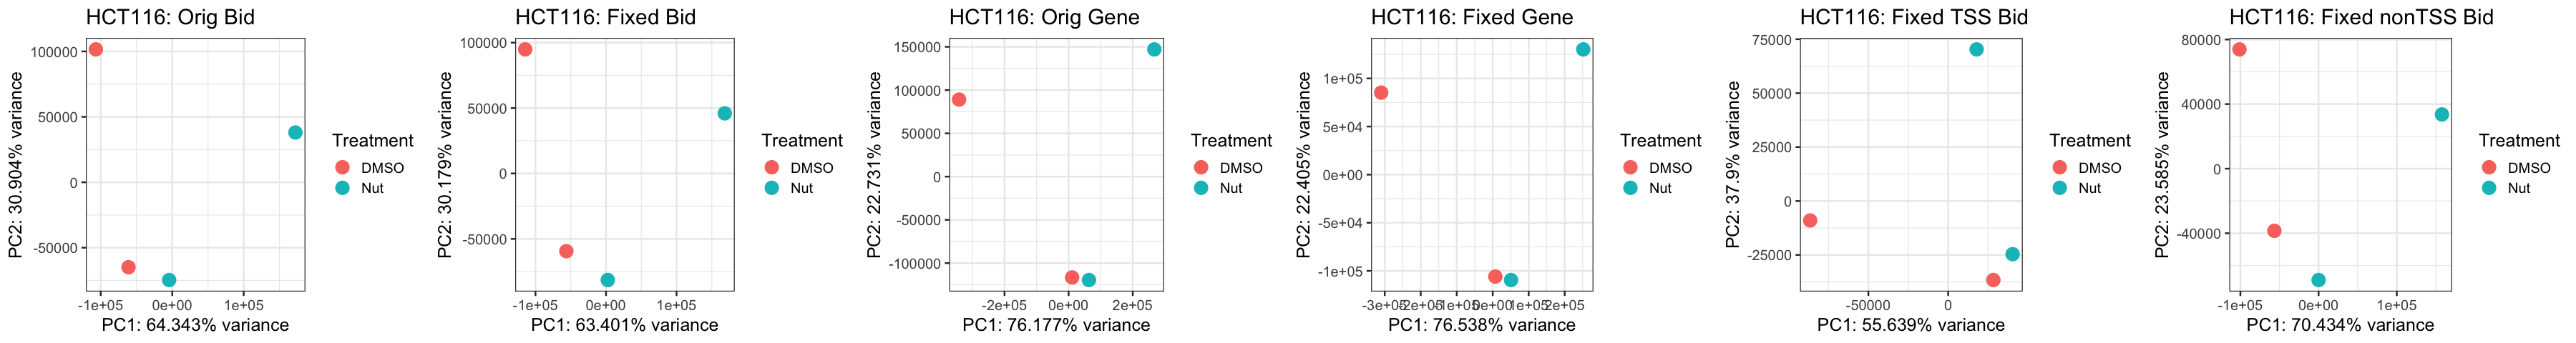

In [128]:

p1 <- plotPCA_hope_meta(bid_counts, metadata=design, ntop=500) + ggtitle(paste0(celltype,": Orig Bid"))
p2 <- plotPCA_hope_meta(bid_fix_counts, metadata=design, ntop=500) + ggtitle(paste0(celltype,": Fixed Bid"))
p3 <- plotPCA_hope_meta(gene_counts, metadata=design, ntop=500) + ggtitle(paste0(celltype,": Orig Gene"))
p4 <- plotPCA_hope_meta(gene_fix_counts, metadata=design, ntop=500) + ggtitle(paste0(celltype,": Fixed Gene"))
p5 <- plotPCA_hope_meta(tss_bid_fix_counts, metadata=design, ntop=500) + ggtitle(paste0(celltype,": Fixed TSS Bid"))
p6 <- plotPCA_hope_meta(nontss_bid_fix_counts, metadata=design, ntop=500) + ggtitle(paste0(celltype,": Fixed nonTSS Bid"))
options(repr.plot.height = 4, repr.plot.width = 30)
plot_grid(p1, p2, p3, p4, p5, p6, nrow=1)

## 1. Run DESeq2

In [129]:
dds_bid <- DESeqDataSetFromMatrix(countData = bid_counts, colData = design, design = ~ Treatment+Replicate)
dds_bid_fix <- DESeqDataSetFromMatrix(countData = bid_fix_counts, colData = design, design = ~ Treatment+Replicate)
dds_tss_bid_fix <- DESeqDataSetFromMatrix(countData = tss_bid_fix_counts, colData = design, design = ~ Treatment+Replicate)
dds_nontss_bid_fix <- DESeqDataSetFromMatrix(countData = nontss_bid_fix_counts, colData = design, design = ~ Treatment+Replicate)
dds_gene <- DESeqDataSetFromMatrix(countData = gene_counts, colData = design, design = ~ Treatment+Replicate)
dds_gene_fix <- DESeqDataSetFromMatrix(countData = gene_fix_counts, colData = design, design = ~ Treatment+Replicate)

In [130]:
isControl_fix <- which(rownames(gene_fix_counts) %in% hk_genes)
isControl <- which(rownames(gene_counts) %in% hk_genes)
length(hk_genes)
gene_hk_counts <- gene_counts[isControl,]
gene_fix_hk_counts <- gene_fix_counts[isControl_fix,]
length(intersect(rownames(gene_fix_hk_counts), hk_genes))
length(intersect(rownames(gene_hk_counts), hk_genes))

[1] 14

[1] 14

[1] 14

### A. Size Factors
Use the control genes

In [131]:
## Ratio
dds_gene_fix_rat = estimateSizeFactors(dds_gene_fix, type="ratio", controlGenes=isControl_fix)
dds_bid_fix_rat = dds_bid_fix
dds_tss_fix_rat = dds_tss_bid_fix
dds_nontss_fix_rat = dds_nontss_bid_fix
sizeFactors(dds_bid_fix_rat) <- sizeFactors(dds_gene_fix_rat)
sizeFactors(dds_tss_fix_rat) <- sizeFactors(dds_gene_fix_rat)
sizeFactors(dds_nontss_fix_rat) <- sizeFactors(dds_gene_fix_rat)

#### Nonfixed counts
dds_gene = estimateSizeFactors(dds_gene, type="ratio", controlGenes=isControl)
sizeFactors(dds_bid) <- sizeFactors(dds_gene)

In [132]:
## Poscounts
dds_gene_fix_pc = estimateSizeFactors(dds_gene_fix, type="poscounts", controlGenes=isControl_fix)
dds_bid_fix_pc = dds_bid_fix
dds_tss_fix_pc = dds_tss_bid_fix
dds_nontss_fix_pc = dds_nontss_bid_fix
sizeFactors(dds_bid_fix_pc) <- sizeFactors(dds_gene_fix_pc)
sizeFactors(dds_tss_fix_pc) <- sizeFactors(dds_gene_fix_pc)
sizeFactors(dds_nontss_fix_pc) <- sizeFactors(dds_gene_fix_pc)

In [133]:
## Iter
dds_gene_fix_iter = estimateSizeFactors(dds_gene_fix, type="iterate", controlGenes=isControl_fix)
dds_bid_fix_iter = dds_bid_fix
dds_tss_fix_iter = dds_tss_bid_fix
dds_nontss_fix_iter = dds_nontss_bid_fix
sizeFactors(dds_bid_fix_iter) <- sizeFactors(dds_gene_fix_iter)
sizeFactors(dds_tss_fix_iter) <- sizeFactors(dds_gene_fix_iter)
sizeFactors(dds_nontss_fix_iter) <- sizeFactors(dds_gene_fix_iter)

In [134]:
# remove the original
rm(dds_bid_fix)
rm(dds_tss_bid_fix)
rm(dds_nontss_bid_fix)
rm(dds_gene_fix)

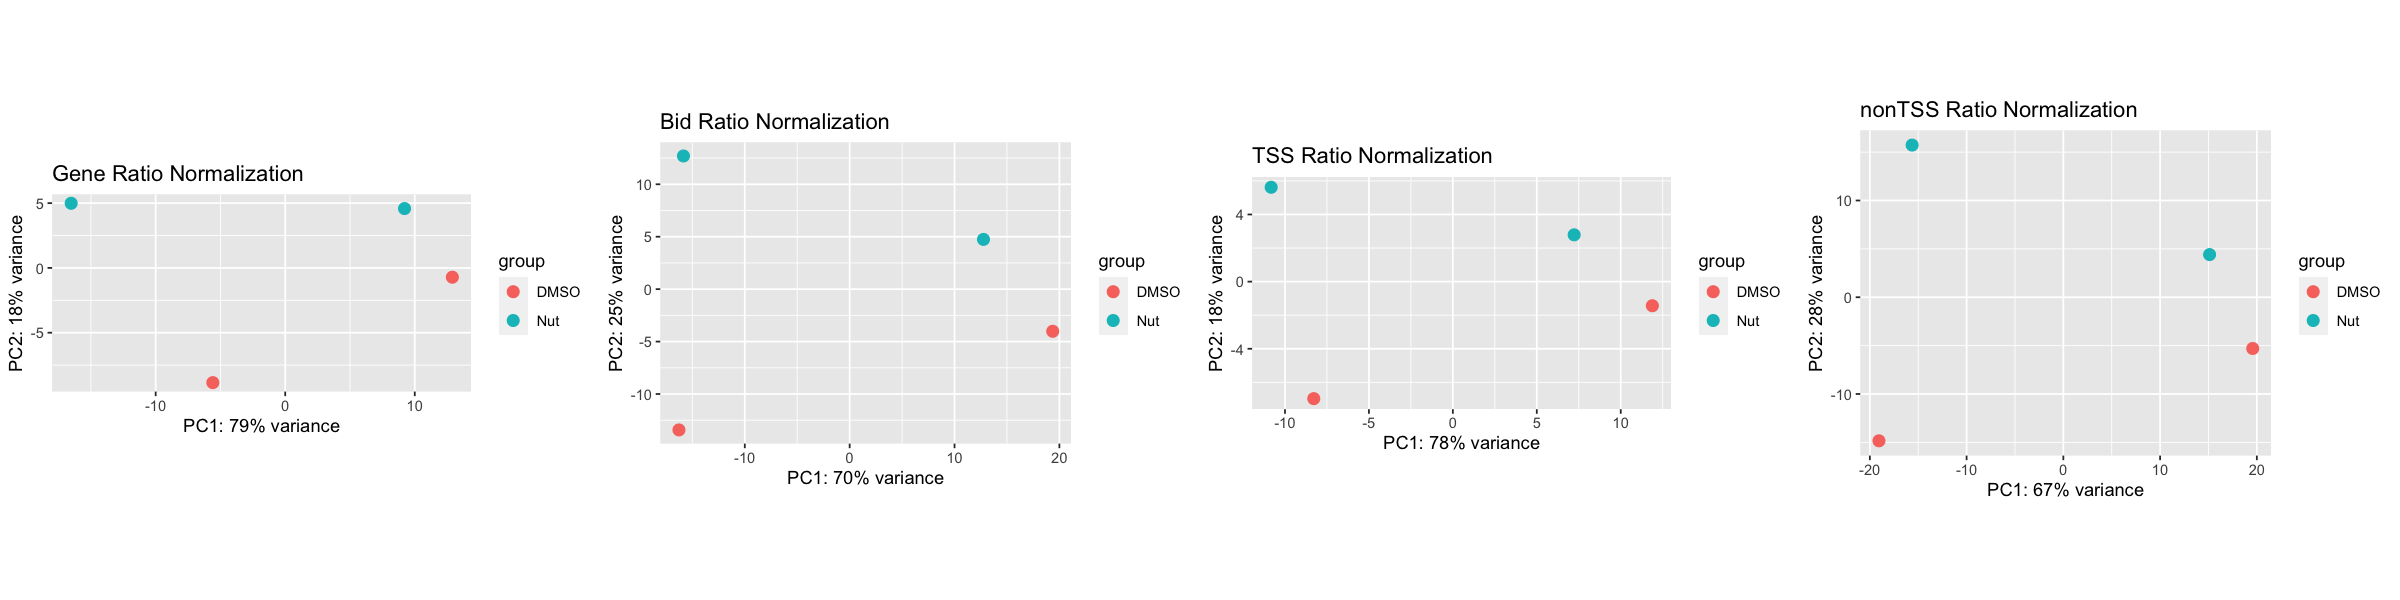

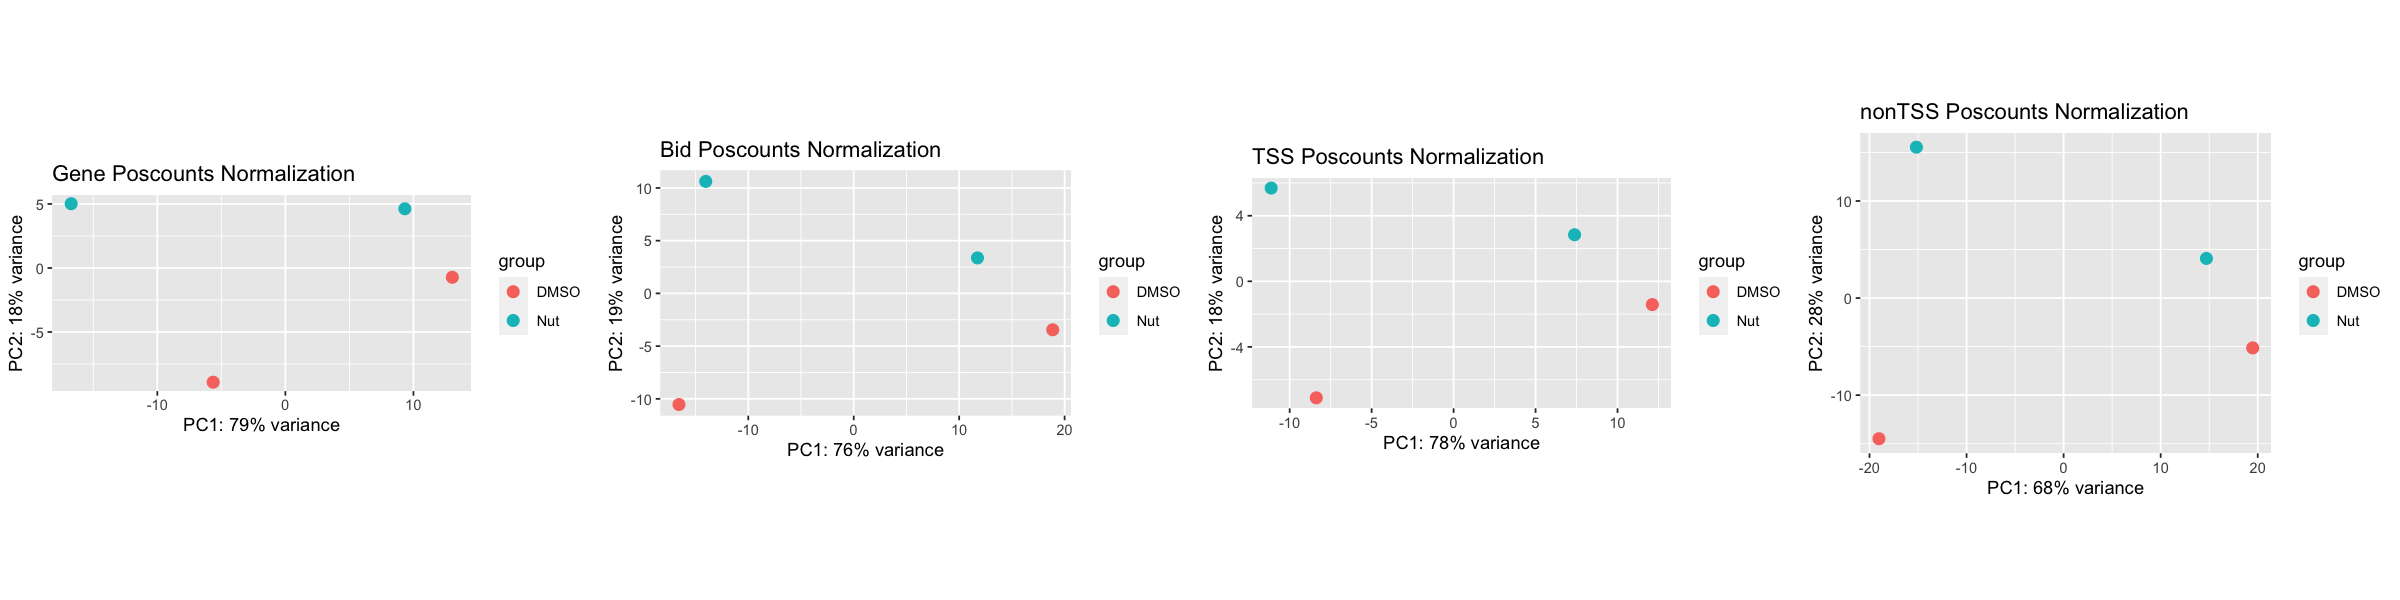

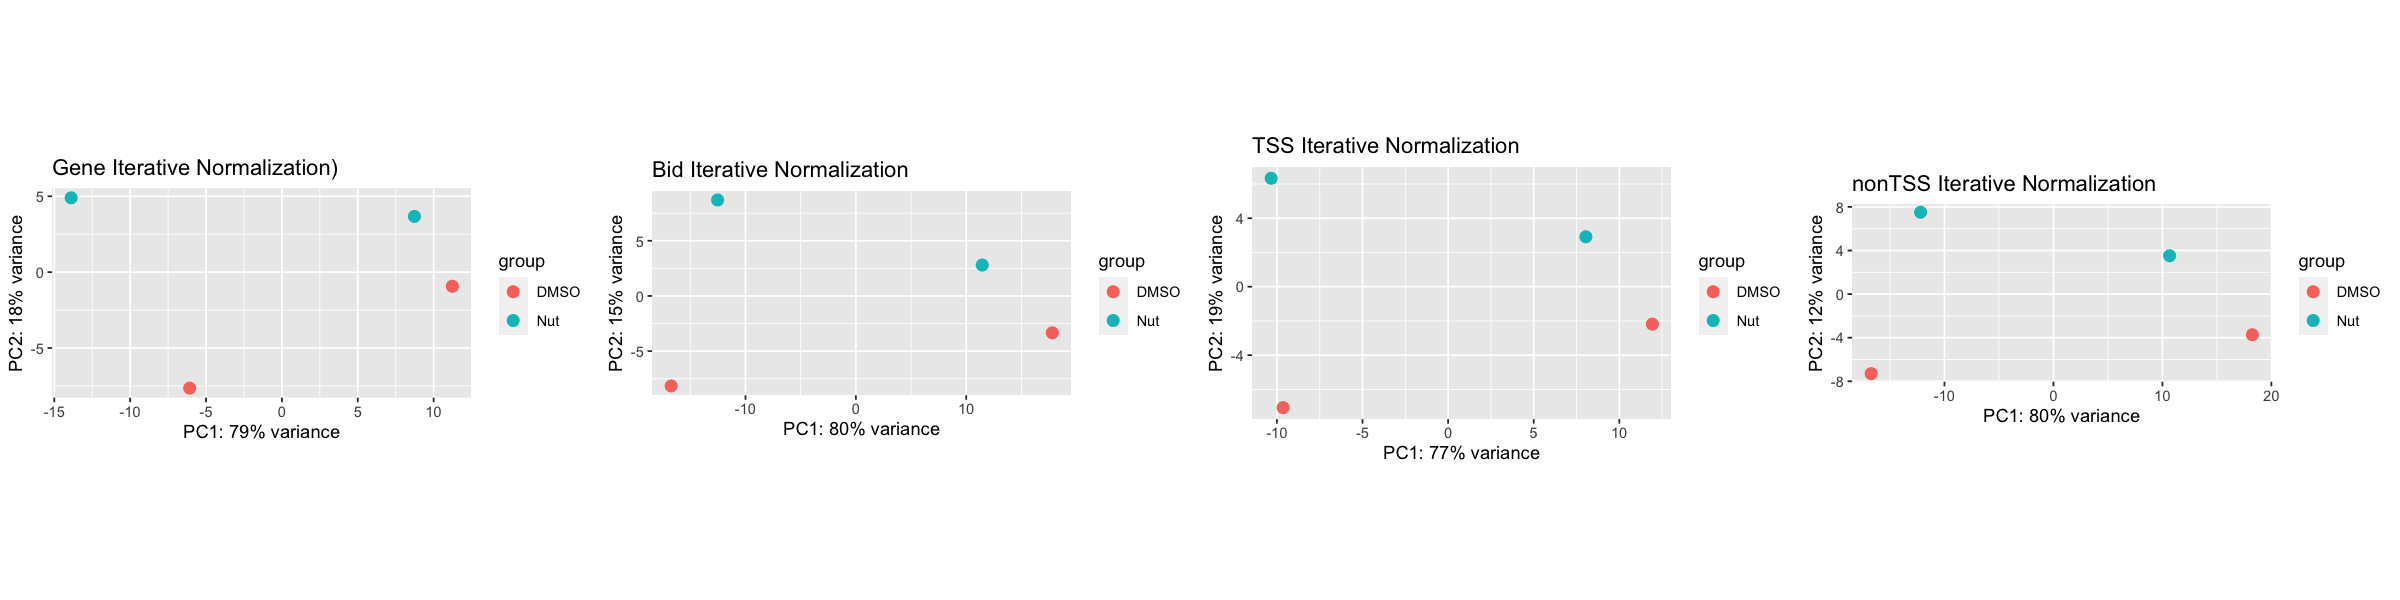

In [135]:
options(repr.plot.width=20, repr.plot.height=5)
# Ratio
vsd1 <- vst(dds_gene_fix_rat, blind = FALSE, fitType='local')
vsd2 <- vst(dds_bid_fix_rat, blind = FALSE, fitType='local')
vsd3 <- vst(dds_tss_fix_rat, blind = FALSE, fitType='local')
vsd4 <- vst(dds_nontss_fix_rat, blind = FALSE, fitType='local')
p1 <- plotPCA(vsd1, intgroup = c("Treatment")) + ggtitle("Gene Ratio Normalization")
p2 <- plotPCA(vsd2, intgroup = c("Treatment")) + ggtitle("Bid Ratio Normalization")
p3 <- plotPCA(vsd3, intgroup = c("Treatment")) + ggtitle("TSS Ratio Normalization")
p4 <- plotPCA(vsd4, intgroup = c("Treatment")) + ggtitle("nonTSS Ratio Normalization")
plot_grid(p1, p2, p3, p4, nrow=1)
# Poscounts
vsd1 <- vst(dds_gene_fix_pc, blind = FALSE, fitType='local')
vsd2 <- vst(dds_bid_fix_pc, blind = FALSE, fitType='local')
vsd3 <- vst(dds_tss_fix_pc, blind = FALSE, fitType='local')
vsd4 <- vst(dds_nontss_fix_pc, blind = FALSE, fitType='local')
p1 <- plotPCA(vsd1, intgroup = c("Treatment")) + ggtitle("Gene Poscounts Normalization")
p2 <- plotPCA(vsd2, intgroup = c("Treatment")) + ggtitle("Bid Poscounts Normalization")
p3 <- plotPCA(vsd3, intgroup = c("Treatment")) + ggtitle("TSS Poscounts Normalization")
p4 <- plotPCA(vsd4, intgroup = c("Treatment")) + ggtitle("nonTSS Poscounts Normalization")
plot_grid(p1, p2, p3, p4, nrow=1)
# Iterative
vsd1 <- vst(dds_gene_fix_iter, blind = FALSE, fitType='local')
vsd2 <- vst(dds_bid_fix_iter, blind = FALSE, fitType='local')
vsd3 <- vst(dds_tss_fix_iter, blind = FALSE, fitType='local')
vsd4 <- vst(dds_nontss_fix_iter, blind = FALSE, fitType='local')
p1 <- plotPCA(vsd1, intgroup = c("Treatment")) + ggtitle("Gene Iterative Normalization)")
p2 <- plotPCA(vsd2, intgroup = c("Treatment")) + ggtitle("Bid Iterative Normalization")
p3 <- plotPCA(vsd3, intgroup = c("Treatment")) + ggtitle("TSS Iterative Normalization")
p4 <- plotPCA(vsd4, intgroup = c("Treatment")) + ggtitle("nonTSS Iterative Normalization")
plot_grid(p1, p2, p3, p4, nrow=1)

### B. Estimate Dispersions

In [136]:
## Ratio
dds_gene_fix_rat_mn = estimateDispersions(dds_gene_fix_rat, fitType="mean")
dds_gene_fix_rat_par = estimateDispersions(dds_gene_fix_rat, fitType="parametric")
dds_gene_fix_rat = estimateDispersions(dds_gene_fix_rat, fitType="local")
dds_bid_fix_rat_mn = estimateDispersions(dds_bid_fix_rat, fitType="mean")
dds_bid_fix_rat_par = estimateDispersions(dds_bid_fix_rat, fitType="parametric")
dds_bid_fix_rat = estimateDispersions(dds_bid_fix_rat, fitType="local")
dds_tss_fix_rat_mn = estimateDispersions(dds_tss_fix_rat, fitType="mean")
dds_tss_fix_rat_par = estimateDispersions(dds_tss_fix_rat, fitType="parametric")
dds_tss_fix_rat = estimateDispersions(dds_tss_fix_rat, fitType="local")
dds_nontss_fix_rat_mn = estimateDispersions(dds_nontss_fix_rat, fitType="mean")
dds_nontss_fix_rat_par = estimateDispersions(dds_nontss_fix_rat, fitType="parametric")
dds_nontss_fix_rat = estimateDispersions(dds_nontss_fix_rat, fitType="local")


#### Nonfixed
dds_gene = estimateDispersions(dds_gene, fitType="local")
dds_bid = estimateDispersions(dds_bid, fitType="local")

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

gene-wise dispersion estimates

mean-dis

In [137]:
## Poscounts
dds_gene_fix_pc_mn = estimateDispersions(dds_gene_fix_pc, fitType="mean")
dds_gene_fix_pc_par = estimateDispersions(dds_gene_fix_pc, fitType="parametric")
dds_gene_fix_pc = estimateDispersions(dds_gene_fix_pc, fitType="local")
dds_bid_fix_pc_mn = estimateDispersions(dds_bid_fix_pc, fitType="mean")
dds_bid_fix_pc_par = estimateDispersions(dds_bid_fix_pc, fitType="parametric")
dds_bid_fix_pc = estimateDispersions(dds_bid_fix_pc, fitType="local")
dds_tss_fix_pc_mn = estimateDispersions(dds_tss_fix_pc, fitType="mean")
dds_tss_fix_pc_par = estimateDispersions(dds_tss_fix_pc, fitType="parametric")
dds_tss_fix_pc = estimateDispersions(dds_tss_fix_pc, fitType="local")
dds_nontss_fix_pc_mn = estimateDispersions(dds_nontss_fix_pc, fitType="mean")
dds_nontss_fix_pc_par = estimateDispersions(dds_nontss_fix_pc, fitType="parametric")
dds_nontss_fix_pc = estimateDispersions(dds_nontss_fix_pc, fitType="local")


gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

gene-wise 

In [138]:
## Iterative
dds_gene_fix_iter_mn = estimateDispersions(dds_gene_fix_iter, fitType="mean")
dds_gene_fix_iter_par = estimateDispersions(dds_gene_fix_iter, fitType="parametric")
dds_gene_fix_iter = estimateDispersions(dds_gene_fix_iter, fitType="local")
dds_bid_fix_iter_mn = estimateDispersions(dds_bid_fix_iter, fitType="mean")
dds_bid_fix_iter_par = estimateDispersions(dds_bid_fix_iter, fitType="parametric")
dds_bid_fix_iter = estimateDispersions(dds_bid_fix_iter, fitType="local")
dds_tss_fix_iter_mn = estimateDispersions(dds_tss_fix_iter, fitType="mean")
dds_tss_fix_iter_par = estimateDispersions(dds_tss_fix_iter, fitType="parametric")
dds_tss_fix_iter = estimateDispersions(dds_tss_fix_iter, fitType="local")
dds_nontss_fix_iter_mn = estimateDispersions(dds_nontss_fix_iter, fitType="mean")
dds_nontss_fix_iter_par = estimateDispersions(dds_nontss_fix_iter, fitType="parametric")
dds_nontss_fix_iter = estimateDispersions(dds_nontss_fix_iter, fitType="local")


gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

gene-wise 

### C. Run Significance Tests

In [139]:
## RATIO ##
dds_gene_fix_rat_mn_Wd <- nbinomWaldTest(dds_gene_fix_rat_mn)
dds_gene_fix_rat_mn_LRT <- nbinomLRT(dds_gene_fix_rat_mn, reduced=~Replicate)
dds_gene_fix_rat_par_Wd <- nbinomWaldTest(dds_gene_fix_rat_par)
dds_gene_fix_rat_par_LRT <- nbinomLRT(dds_gene_fix_rat_par, reduced=~Replicate)
dds_gene_fix_rat_Wd <- nbinomWaldTest(dds_gene_fix_rat)
dds_gene_fix_rat_LRT <- nbinomLRT(dds_gene_fix_rat, reduced=~Replicate)

dds_bid_fix_rat_mn_Wd <- nbinomWaldTest(dds_bid_fix_rat_mn)
dds_bid_fix_rat_mn_LRT <- nbinomLRT(dds_bid_fix_rat_mn, reduced=~Replicate)
dds_bid_fix_rat_par_Wd <- nbinomWaldTest(dds_bid_fix_rat_par)
dds_bid_fix_rat_par_LRT <- nbinomLRT(dds_bid_fix_rat_par, reduced=~Replicate)
dds_bid_fix_rat_Wd <- nbinomWaldTest(dds_bid_fix_rat)
dds_bid_fix_rat_LRT <- nbinomLRT(dds_bid_fix_rat, reduced=~Replicate)

dds_tss_fix_rat_mn_Wd <- nbinomWaldTest(dds_tss_fix_rat_mn)
dds_tss_fix_rat_mn_LRT <- nbinomLRT(dds_tss_fix_rat_mn, reduced=~Replicate)
dds_tss_fix_rat_par_Wd <- nbinomWaldTest(dds_tss_fix_rat_par)
dds_tss_fix_rat_par_LRT <- nbinomLRT(dds_tss_fix_rat_par, reduced=~Replicate)
dds_tss_fix_rat_Wd <- nbinomWaldTest(dds_tss_fix_rat)
dds_tss_fix_rat_LRT <- nbinomLRT(dds_tss_fix_rat, reduced=~Replicate)

dds_nontss_fix_rat_mn_Wd <- nbinomWaldTest(dds_nontss_fix_rat_mn)
dds_nontss_fix_rat_mn_LRT <- nbinomLRT(dds_nontss_fix_rat_mn, reduced=~Replicate)
dds_nontss_fix_rat_par_Wd <- nbinomWaldTest(dds_nontss_fix_rat_par)
dds_nontss_fix_rat_par_LRT <- nbinomLRT(dds_nontss_fix_rat_par, reduced=~Replicate)
dds_nontss_fix_rat_Wd <- nbinomWaldTest(dds_nontss_fix_rat)
dds_nontss_fix_rat_LRT <- nbinomLRT(dds_nontss_fix_rat, reduced=~Replicate)

#### Nonfixed
dds_gene = nbinomWaldTest(dds_gene)
dds_bid = nbinomWaldTest(dds_bid)

In [140]:
## Poscounts  ##
dds_gene_fix_pc_mn_Wd <- nbinomWaldTest(dds_gene_fix_pc_mn)
dds_gene_fix_pc_mn_LRT <- nbinomLRT(dds_gene_fix_pc_mn, reduced=~Replicate)
dds_gene_fix_pc_par_Wd <- nbinomWaldTest(dds_gene_fix_pc_par)
dds_gene_fix_pc_par_LRT <- nbinomLRT(dds_gene_fix_pc_par, reduced=~Replicate)
dds_gene_fix_pc_Wd <- nbinomWaldTest(dds_gene_fix_pc)
dds_gene_fix_pc_LRT <- nbinomLRT(dds_gene_fix_pc, reduced=~Replicate)

dds_bid_fix_pc_mn_Wd <- nbinomWaldTest(dds_bid_fix_pc_mn)
dds_bid_fix_pc_mn_LRT <- nbinomLRT(dds_bid_fix_pc_mn, reduced=~Replicate)
dds_bid_fix_pc_par_Wd <- nbinomWaldTest(dds_bid_fix_pc_par)
dds_bid_fix_pc_par_LRT <- nbinomLRT(dds_bid_fix_pc_par, reduced=~Replicate)
dds_bid_fix_pc_Wd <- nbinomWaldTest(dds_bid_fix_pc)
dds_bid_fix_pc_LRT <- nbinomLRT(dds_bid_fix_pc, reduced=~Replicate)

dds_tss_fix_pc_mn_Wd <- nbinomWaldTest(dds_tss_fix_pc_mn)
dds_tss_fix_pc_mn_LRT <- nbinomLRT(dds_tss_fix_pc_mn, reduced=~Replicate)
dds_tss_fix_pc_par_Wd <- nbinomWaldTest(dds_tss_fix_pc_par)
dds_tss_fix_pc_par_LRT <- nbinomLRT(dds_tss_fix_pc_par, reduced=~Replicate)
dds_tss_fix_pc_Wd <- nbinomWaldTest(dds_tss_fix_pc)
dds_tss_fix_pc_LRT <- nbinomLRT(dds_tss_fix_pc, reduced=~Replicate)

dds_nontss_fix_pc_mn_Wd <- nbinomWaldTest(dds_nontss_fix_pc_mn)
dds_nontss_fix_pc_mn_LRT <- nbinomLRT(dds_nontss_fix_pc_mn, reduced=~Replicate)
dds_nontss_fix_pc_par_Wd <- nbinomWaldTest(dds_nontss_fix_pc_par)
dds_nontss_fix_pc_par_LRT <- nbinomLRT(dds_nontss_fix_pc_par, reduced=~Replicate)
dds_nontss_fix_pc_Wd <- nbinomWaldTest(dds_nontss_fix_pc)
dds_nontss_fix_pc_LRT <- nbinomLRT(dds_nontss_fix_pc, reduced=~Replicate)


In [141]:
## Iterative  ##
dds_gene_fix_iter_mn_Wd <- nbinomWaldTest(dds_gene_fix_iter_mn)
dds_gene_fix_iter_mn_LRT <- nbinomLRT(dds_gene_fix_iter_mn, reduced=~Replicate)
dds_gene_fix_iter_par_Wd <- nbinomWaldTest(dds_gene_fix_iter_par)
dds_gene_fix_iter_par_LRT <- nbinomLRT(dds_gene_fix_iter_par, reduced=~Replicate)
dds_gene_fix_iter_Wd <- nbinomWaldTest(dds_gene_fix_iter)
dds_gene_fix_iter_LRT <- nbinomLRT(dds_gene_fix_iter, reduced=~Replicate)

dds_bid_fix_iter_mn_Wd <- nbinomWaldTest(dds_bid_fix_iter_mn)
dds_bid_fix_iter_mn_LRT <- nbinomLRT(dds_bid_fix_iter_mn, reduced=~Replicate)
dds_bid_fix_iter_par_Wd <- nbinomWaldTest(dds_bid_fix_iter_par)
dds_bid_fix_iter_par_LRT <- nbinomLRT(dds_bid_fix_iter_par, reduced=~Replicate)
dds_bid_fix_iter_Wd <- nbinomWaldTest(dds_bid_fix_iter)
dds_bid_fix_iter_LRT <- nbinomLRT(dds_bid_fix_iter, reduced=~Replicate)

dds_tss_fix_iter_mn_Wd <- nbinomWaldTest(dds_tss_fix_iter_mn)
dds_tss_fix_iter_mn_LRT <- nbinomLRT(dds_tss_fix_iter_mn, reduced=~Replicate)
dds_tss_fix_iter_par_Wd <- nbinomWaldTest(dds_tss_fix_iter_par)
dds_tss_fix_iter_par_LRT <- nbinomLRT(dds_tss_fix_iter_par, reduced=~Replicate)
dds_tss_fix_iter_Wd <- nbinomWaldTest(dds_tss_fix_iter)
dds_tss_fix_iter_LRT <- nbinomLRT(dds_tss_fix_iter, reduced=~Replicate)

dds_nontss_fix_iter_mn_Wd <- nbinomWaldTest(dds_nontss_fix_iter_mn)
dds_nontss_fix_iter_mn_LRT <- nbinomLRT(dds_nontss_fix_iter_mn, reduced=~Replicate)
dds_nontss_fix_iter_par_Wd <- nbinomWaldTest(dds_nontss_fix_iter_par)
dds_nontss_fix_iter_par_LRT <- nbinomLRT(dds_nontss_fix_iter_par, reduced=~Replicate)
dds_nontss_fix_iter_Wd <- nbinomWaldTest(dds_nontss_fix_iter)
dds_nontss_fix_iter_LRT <- nbinomLRT(dds_nontss_fix_iter, reduced=~Replicate)


### D. Get Summary Stats

In [142]:
name_list = c(rep("Bid", 18), rep("TSS", 18), rep("NonTSS", 18),  rep("Gene", 18), 
              "Orig_Bid",  "Orig_Gene")
test_list = c(rep(c("Wald", "Wald", "Wald", "LRT", "LRT", "LRT"), 12), "Wald", "Wald")
norm_list = c(rep(c(rep("Ratio", 6), rep("Poscounts", 6), rep("Iterative", 6)), 4), "Ratio", "Ratio")
disp_list = c(rep(c("Mean", "Parametric", "Local"), 6*4), "Local", "Local")

dds_list <- list(dds_bid_fix_rat_mn_Wd, dds_bid_fix_rat_par_Wd, dds_bid_fix_rat_Wd,  dds_bid_fix_rat_mn_LRT, dds_bid_fix_rat_par_LRT, dds_bid_fix_rat_LRT,
                 dds_bid_fix_pc_mn_Wd, dds_bid_fix_pc_par_Wd, dds_bid_fix_pc_Wd,  dds_bid_fix_pc_mn_LRT, dds_bid_fix_pc_par_LRT, dds_bid_fix_pc_LRT,
                 dds_bid_fix_iter_mn_Wd, dds_bid_fix_iter_par_Wd, dds_bid_fix_iter_Wd,  dds_bid_fix_iter_mn_LRT, dds_bid_fix_iter_par_LRT, dds_bid_fix_iter_LRT,
                 
                 dds_tss_fix_rat_mn_Wd, dds_tss_fix_rat_par_Wd, dds_tss_fix_rat_Wd,  dds_tss_fix_rat_mn_LRT, dds_tss_fix_rat_par_LRT, dds_tss_fix_rat_LRT,
                 dds_tss_fix_pc_mn_Wd, dds_tss_fix_pc_par_Wd, dds_tss_fix_pc_Wd,  dds_tss_fix_pc_mn_LRT, dds_tss_fix_pc_par_LRT, dds_tss_fix_pc_LRT,
                 dds_tss_fix_iter_mn_Wd, dds_tss_fix_iter_par_Wd, dds_tss_fix_iter_Wd,  dds_tss_fix_iter_mn_LRT, dds_tss_fix_iter_par_LRT, dds_tss_fix_iter_LRT,

                 dds_nontss_fix_rat_mn_Wd, dds_nontss_fix_rat_par_Wd, dds_nontss_fix_rat_Wd,  dds_nontss_fix_rat_mn_LRT, dds_nontss_fix_rat_par_LRT, dds_nontss_fix_rat_LRT,
                 dds_nontss_fix_pc_mn_Wd, dds_nontss_fix_pc_par_Wd, dds_nontss_fix_pc_Wd,  dds_nontss_fix_pc_mn_LRT, dds_nontss_fix_pc_par_LRT, dds_nontss_fix_pc_LRT,
                 dds_nontss_fix_iter_mn_Wd, dds_nontss_fix_iter_par_Wd, dds_nontss_fix_iter_Wd,  dds_nontss_fix_iter_mn_LRT, dds_nontss_fix_iter_par_LRT, dds_nontss_fix_iter_LRT,
                 
                 dds_gene_fix_rat_mn_Wd, dds_gene_fix_rat_par_Wd, dds_gene_fix_rat_Wd,  dds_gene_fix_rat_mn_LRT, dds_gene_fix_rat_par_LRT, dds_gene_fix_rat_LRT,
                 dds_gene_fix_pc_mn_Wd, dds_gene_fix_pc_par_Wd, dds_gene_fix_pc_Wd,  dds_gene_fix_pc_mn_LRT, dds_gene_fix_pc_par_LRT, dds_gene_fix_pc_LRT,
                 dds_gene_fix_iter_mn_Wd, dds_gene_fix_iter_par_Wd, dds_gene_fix_iter_Wd,  dds_gene_fix_iter_mn_LRT, dds_gene_fix_iter_par_LRT, dds_gene_fix_iter_LRT, 
                
                 dds_bid, dds_gene)

cat(length(name_list), length(test_list), length(norm_list), length(disp_list), length(dds_list))   
                   

74 74 74 74 74

In [143]:
contrast = c("Treatment", "DMSO", "Nut")

In [144]:
outdir

[1] "/Users/hopekirby/Desktop/TF_Enh_Linking/Bench_DE/p53/out/"

In [145]:
get_DESeq_stats <- function(results_dict, name, celltype, res, test, norm, disp) {
    #####################
    ## Get sig results ##
    ressig <- data.frame(subset(res, padj < 0.05))
    save = ressig[,c("log2FoldChange", "padj")]
    ####################
    results_dict[["platform"]] <- c(results_dict[["platform"]], "DESeq2")
    results_dict <- get_results_dict(results_dict, name, test, norm, disp, ressig)
    # ###############################################
    # ## Save the significant results ##
    filename <- paste0(outdir, "results/", celltype, "_ressig_DESeq2_", name, "_", norm, "_", test, "_", disp, ".txt")
    write.table(save, filename, quote=FALSE, sep="\t")
    return(results_dict)
    }

In [146]:
results_dict_DE = list("name"=c(), "platform"=c(), "test"=c(), "disp"=c(), "norm"=c(), "Tot_Sig"=c(), 
                    "TP_eartar"=c(), "TP_ctknown"=c(), "TP_chip"=c(), "FP_chip_mean"=c(), "FP_chip_median"=c(), "FP_chip_sd"=c())

#pdf(paste0(outdir, "plots/", celltype, "_DESeq2_plots.pdf"), onefile=TRUE)
binwidth_use=0.05
for (indx in seq(1, length(name_list))) {
    ptitle=paste0(name_list[indx], "_", test_list[indx], "_", norm_list[indx], "_", disp_list[indx])
    # plot dispersions
    # plotDispEsts(dds_list[[indx]], main=ptitle)
    # get the results
    res = results(dds_list[[indx]], contrast, alpha=0.05)
    # ## Plot p-values
    # pl <- ggplot(data.frame(res), aes(x=pvalue)) + geom_histogram(fill="grey64", binwidth=binwidth_use, color="black", boundary=0) + theme_bw(base_size=15) + 
    #    geom_vline(xintercept=0.05, color="red") + ggtitle(ptitle)
    # print(pl)
    # if (name_list[indx] %in% c("Bid", "TSS", "NonTSS") & norm_list[indx]=="Ratio") {
    #     filename <- paste0(outdir, "results/RESULTS_", celltype, "_DESeq2_", name_list[indx], "_", norm_list[indx], "_", test_list[indx], "_", disp_list[indx], ".txt")
    #     write.table(res[,c("baseMean", "log2FoldChange", "pvalue", "padj")], filename, quote=FALSE, sep="\t")

    results_dict_DE = get_DESeq_stats(results_dict_DE, name_list[indx], celltype, 
                                      res, test=test_list[indx], norm=norm_list[indx], disp=disp_list[indx])
    
    }
# dev.off()
# graphics.off()
results_dict_DE <- as.data.frame(results_dict_DE)
# results_dict_DE[1:5,]
# dim(results_dict_DE)

## 2. Prep for Limma & Voom

### 2A. DGEList Objects

In [147]:
d0_bid <- DGEList(bid_counts, samples=design, group = design$Treatment)
d0_bid_fix <- DGEList(bid_fix_counts, samples=design, group = design$Treatment)
d0_tss_bid_fix <- DGEList(tss_bid_fix_counts, samples=design, group = design$Treatment)
d0_nontss_bid_fix <- DGEList(nontss_bid_fix_counts, samples=design, group = design$Treatment)
d0_gene <- DGEList(gene_counts, samples=design, group = design$Treatment)
d0_gene_fix <- DGEList(gene_fix_counts, csamples=design, group = design$Treatment)

# for normalization only (just using hk)
d0_gene_hk <- DGEList(gene_hk_counts, samples=design, group = design$Treatment)
d0_gene_fix_hk <- DGEList(gene_fix_hk_counts, samples=design, group = design$Treatment)

### 2B. Normalization

In [148]:
### TMM
d0_gene_hk = calcNormFactors(d0_gene_hk)
d0_gene_fix_hk = calcNormFactors(d0_gene_fix_hk)
cat(d0_gene_hk$samples$norm.factors)
d0_gene$samples$norm.factors  = d0_gene_hk$samples$norm.factors
d0_gene_fix$samples$norm.factors  = d0_gene_fix_hk$samples$norm.factors
# full
d0_bid$samples$norm.factors  = d0_gene_hk$samples$norm.factors
d0_bid_fix$samples$norm.factors  = d0_gene_fix_hk$samples$norm.factors
# tss
d0_tss_bid_fix$samples$norm.factors  = d0_gene_fix_hk$samples$norm.factors
# nontss
d0_nontss_bid_fix$samples$norm.factors  = d0_gene_fix_hk$samples$norm.factors

1.025912 0.9895752 1.000204 0.9848107

In [149]:
### TMMwsp
d0_gene_fix_hk = calcNormFactors(d0_gene_fix_hk, method="TMMwsp")
d0_gene_fix_tw <- d0_gene_fix
d0_gene_fix_tw$samples$norm.factors  = d0_gene_fix_hk$samples$norm.factors
# full
d0_bid_fix_tw <- d0_bid_fix
d0_bid_fix_tw$samples$norm.factors  = d0_gene_fix_hk$samples$norm.factors
# tss
d0_tss_bid_fix_tw <- d0_tss_bid_fix
d0_tss_bid_fix_tw$samples$norm.factors  = d0_gene_fix_hk$samples$norm.factors
# nontss
d0_nontss_bid_fix_tw <- d0_nontss_bid_fix
d0_nontss_bid_fix_tw$samples$norm.factors  = d0_gene_fix_hk$samples$norm.factors

In [150]:
### RLE
d0_gene_fix_hk = calcNormFactors(d0_gene_fix_hk, method="RLE")
d0_gene_fix_rle <- d0_gene_fix
d0_gene_fix_rle$samples$norm.factors  = d0_gene_fix_hk$samples$norm.factors
# full
d0_bid_fix_rle <- d0_bid_fix
d0_bid_fix_rle$samples$norm.factors  = d0_gene_fix_hk$samples$norm.factors
# tss
d0_tss_bid_fix_rle <- d0_tss_bid_fix
d0_tss_bid_fix_rle$samples$norm.factors  = d0_gene_fix_hk$samples$norm.factors
# nontss
d0_nontss_bid_fix_rle <- d0_nontss_bid_fix
d0_nontss_bid_fix_rle$samples$norm.factors  = d0_gene_fix_hk$samples$norm.factors

In [151]:
### Upperquartile
d0_gene_fix_hk = calcNormFactors(d0_gene_fix_hk, method="upperquartile")
d0_gene_fix_uq <- d0_gene_fix
d0_gene_fix_uq$samples$norm.factors  = d0_gene_fix_hk$samples$norm.factors
# full
d0_bid_fix_uq <- d0_bid_fix
d0_bid_fix_uq$samples$norm.factors  = d0_gene_fix_hk$samples$norm.factors
# tss
d0_tss_bid_fix_uq <- d0_tss_bid_fix
d0_tss_bid_fix_uq$samples$norm.factors  = d0_gene_fix_hk$samples$norm.factors
# nontss
d0_nontss_bid_fix_uq <- d0_nontss_bid_fix
d0_nontss_bid_fix_uq$samples$norm.factors  = d0_gene_fix_hk$samples$norm.factors

In [152]:
### TMM (EVALUATING HOW BIG DIFFERENCES ARE IN NORM FACTORS CALCULATED
d0_gene_hk = calcNormFactors(d0_gene_hk)
d0_gene_fix_hk = calcNormFactors(d0_gene_fix_hk)
d0_gene_fix = calcNormFactors(d0_gene_fix)
cat(d0_gene_fix$samples$norm.factors, "\n", d0_gene_fix_hk$samples$norm.factors)

1.028703 0.9880209 0.9971262 0.9867196 
 1.010337 0.9819894 1.023205 0.9850639

In [153]:
# Consider the differences in the "sizeFactor" like numbers
cat(d0_gene_fix$samples$norm.factors*d0_gene_fix$samples$lib.size/10000000, "\n",
      d0_gene_fix_tw$samples$norm.factors*d0_gene_fix_tw$samples$lib.size/10000000, "\n",
      d0_gene_fix_rle$samples$norm.factors*d0_gene_fix_rle$samples$lib.size/10000000,  "\n",
      d0_gene_fix_uq$samples$norm.factors*d0_gene_fix_uq$samples$lib.size/10000000, "\n",
   sizeFactors(dds_gene_fix_rat), "\n",
   sizeFactors(dds_gene_fix_pc), "\n",
   sizeFactors(dds_gene_fix_iter))

1.633582 4.188366 5.324152 4.450766 
 1.62893 4.125436 5.415217 4.455357 
 1.609461 4.178383 5.481573 4.39822 
 1.499444 4.17334 5.600885 4.625941 
 0.4434534 1.229997 1.396996 1.275785 
 0.4465981 1.238719 1.406903 1.284831 
 0.4633398 1.170259 1.484716 1.242152

In [154]:
rm(list=ls(pattern="dds_"))
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,7918959,423.0,13877181,741.2,13877181,741.2
Vcells,382396289,2917.5,744144851,5677.4,744142572,5677.4


### 2C. Preassessment

In [155]:
pdf(paste0(outdir, "plots/", celltype, "_Limma_EdgeR_MDSs.pdf"), onefile=TRUE)
options(repr.plot.height = 6, repr.plot.width = 6)
plotMDS(d0_gene, labels=design$Treatment, main = paste0(celltype, " Orig Gene, TMM normalization"))
plotMDS(d0_gene_fix, labels=design$Treatment, main = paste0(celltype, " Gene TMM normalization"))
plotMDS(d0_bid, labels=design$Treatment, main = paste0(celltype, " Orig Bid, TMM normalization"))
plotMDS(d0_bid_fix, labels=design$Treatment, main = paste0(celltype, " Bid TMM normalization"))
plotMDS(d0_tss_bid_fix, labels=design$Treatment, main = paste0(celltype, " TSS Bids TMM normalization"))
plotMDS(d0_nontss_bid_fix, labels=design$Treatment, main = paste0(celltype, " nonTSS Bids TMM normalization"))
plotMDS(d0_gene_fix_tw, labels=design$Treatment, main = paste0(celltype, " Gene TMMwsp normalization"))
plotMDS(d0_bid_fix_tw, labels=design$Treatment, main = paste0(celltype, " Bid TMMwsp normalization"))
plotMDS(d0_tss_bid_fix_tw, labels=design$Treatment, main = paste0(celltype, " TSS Bids TMMwsp normalization"))
plotMDS(d0_nontss_bid_fix_tw, labels=design$Treatment, main = paste0(celltype, " nonTSS Bids TMMwsp normalization"))
plotMDS(d0_gene_fix_rle, labels=design$Treatment, main = paste0(celltype, " Gene RLE normalization"))
plotMDS(d0_bid_fix_rle, labels=design$Treatment, main = paste0(celltype, " Bid RLE normalization"))
plotMDS(d0_tss_bid_fix_rle, labels=design$Treatment, main = paste0(celltype, " TSS Bids RLE normalization"))
plotMDS(d0_nontss_bid_fix_rle, labels=design$Treatment, main = paste0(celltype, " nonTSS Bids RLE normalization"))
plotMDS(d0_gene_fix_uq, labels=design$Treatment, main = paste0(celltype, " Gene UpQuart normalization"))
plotMDS(d0_bid_fix_uq, labels=design$Treatment, main = paste0(celltype, " Bid UpQuart normalization"))
plotMDS(d0_tss_bid_fix_uq, labels=design$Treatment, main = paste0(celltype, " TSS Bids UpQuart normalization"))
plotMDS(d0_nontss_bid_fix_uq, labels=design$Treatment, main = paste0(celltype, " nonTSS Bids UpQuart normalization"))
dev.off()

pdf 
  2

## 3. DE with Limma-Voom (with quality) or Trend

In [156]:
design
Replicate = design$Replicate
Treatment = design$Treatment
design_mat = model.matrix(~Replicate+Treatment)
colnames(design_mat) <- c("Intercept", "ReplicateR2", "TreatmentNut")
design_mat

Name,Replicate,Treatment
<chr>,<fct>,<fct>
HCT116_DMSO_R1,R1,DMSO
HCT116_DMSO_R2,R2,DMSO
HCT116_Nut_R1,R1,Nut
HCT116_Nut_R2,R2,Nut


,Intercept,ReplicateR2,TreatmentNut
1,1,0,0
2,1,1,0
3,1,0,1
4,1,1,1


In [157]:
coefficient="TreatmentNut"

### 3A. Trend

In [158]:
## TREND TMM normalization
logCPM <- cpm(d0_gene, log=TRUE, prior.count=0.5) ## need to check prior count
fit <- lmFit(logCPM, design_mat)
t_gene <- eBayes(fit, trend=TRUE)

logCPM <- cpm(d0_gene_fix, log=TRUE, prior.count=0.5) ## need to check prior count
fit <- lmFit(logCPM, design_mat)
t_gene_fix <- eBayes(fit, trend=TRUE)
t_gene_fix_rob <- eBayes(fit, trend=TRUE, robust=TRUE)

logCPM <- cpm(d0_bid, log=TRUE, prior.count=0.5) ## need to check prior count
fit <- lmFit(logCPM, design_mat)
t_bid <- eBayes(fit, trend=TRUE)

logCPM <- cpm(d0_bid_fix, log=TRUE, prior.count=0.5) ## need to check prior count
fit <- lmFit(logCPM, design_mat)
t_bid_fix <- eBayes(fit, trend=TRUE)
t_bid_fix_rob <- eBayes(fit, trend=TRUE, robust=TRUE)

logCPM <- cpm(d0_tss_bid_fix, log=TRUE, prior.count=0.5) ## need to check prior count
fit <- lmFit(logCPM, design_mat)
t_tss_bid_fix <- eBayes(fit, trend=TRUE)
t_tss_bid_fix_rob <- eBayes(fit, trend=TRUE, robust=TRUE)

logCPM <- cpm(d0_nontss_bid_fix, log=TRUE, prior.count=0.5) ## need to check prior count
fit <- lmFit(logCPM, design_mat)
t_nontss_bid_fix <- eBayes(fit, trend=TRUE)
t_nontss_bid_fix_rob <- eBayes(fit, trend=TRUE, robust=TRUE)


In [159]:
## TREND TMM wsp
logCPM <- cpm(d0_gene_fix_tw, log=TRUE, prior.count=0.5) ## need to check prior count
fit <- lmFit(logCPM, design_mat)
t_gene_fix_tw <- eBayes(fit, trend=TRUE)
t_gene_fix_tw_rob <- eBayes(fit, trend=TRUE, robust=TRUE)

logCPM <- cpm(d0_bid_fix_tw, log=TRUE, prior.count=0.5) ## need to check prior count
fit <- lmFit(logCPM, design_mat)
t_bid_fix_tw <- eBayes(fit, trend=TRUE)
t_bid_fix_tw_rob <- eBayes(fit, trend=TRUE, robust=TRUE)

logCPM <- cpm(d0_tss_bid_fix_tw, log=TRUE, prior.count=0.5) ## need to check prior count
fit <- lmFit(logCPM, design_mat)
t_tss_bid_fix_tw <- eBayes(fit, trend=TRUE)
t_tss_bid_fix_tw_rob <- eBayes(fit, trend=TRUE, robust=TRUE)

logCPM <- cpm(d0_nontss_bid_fix_tw, log=TRUE, prior.count=0.5) ## need to check prior count
fit <- lmFit(logCPM, design_mat)
t_nontss_bid_fix_tw <- eBayes(fit, trend=TRUE)
t_nontss_bid_fix_tw_rob <- eBayes(fit, trend=TRUE, robust=TRUE)


Warning message:
“One very small variance detected, has been offset away from zero”


In [160]:
## TREND RLE
logCPM <- cpm(d0_gene_fix_rle, log=TRUE, prior.count=0.5) ## need to check prior count
fit <- lmFit(logCPM, design_mat)
t_gene_fix_rle <- eBayes(fit, trend=TRUE)
t_gene_fix_rle_rob <- eBayes(fit, trend=TRUE, robust=TRUE)

logCPM <- cpm(d0_bid_fix_rle, log=TRUE, prior.count=0.5) ## need to check prior count
fit <- lmFit(logCPM, design_mat)
t_bid_fix_rle <- eBayes(fit, trend=TRUE)
t_bid_fix_rle_rob <- eBayes(fit, trend=TRUE, robust=TRUE)

logCPM <- cpm(d0_tss_bid_fix_rle, log=TRUE, prior.count=0.5) ## need to check prior count
fit <- lmFit(logCPM, design_mat)
t_tss_bid_fix_rle <- eBayes(fit, trend=TRUE)
t_tss_bid_fix_rle_rob <- eBayes(fit, trend=TRUE, robust=TRUE)

logCPM <- cpm(d0_nontss_bid_fix_rle, log=TRUE, prior.count=0.5) ## need to check prior count
fit <- lmFit(logCPM, design_mat)
t_nontss_bid_fix_rle <- eBayes(fit, trend=TRUE)
t_nontss_bid_fix_rle_rob <- eBayes(fit, trend=TRUE, robust=TRUE)


In [161]:
## TREND Upper quartile normalization
logCPM <- cpm(d0_gene_fix_uq, log=TRUE, prior.count=0.5) ## need to check prior count
fit <- lmFit(logCPM, design_mat)
t_gene_fix_uq <- eBayes(fit, trend=TRUE)
t_gene_fix_uq_rob <- eBayes(fit, trend=TRUE, robust=TRUE)

logCPM <- cpm(d0_bid_fix_uq, log=TRUE, prior.count=0.5) ## need to check prior count
fit <- lmFit(logCPM, design_mat)
t_bid_fix_uq <- eBayes(fit, trend=TRUE)
t_bid_fix_uq_rob <- eBayes(fit, trend=TRUE, robust=TRUE)

logCPM <- cpm(d0_tss_bid_fix_uq, log=TRUE, prior.count=0.5) ## need to check prior count
fit <- lmFit(logCPM, design_mat)
t_tss_bid_fix_uq <- eBayes(fit, trend=TRUE)
t_tss_bid_fix_uq_rob <- eBayes(fit, trend=TRUE, robust=TRUE)

logCPM <- cpm(d0_nontss_bid_fix_uq, log=TRUE, prior.count=0.5) ## need to check prior count
fit <- lmFit(logCPM, design_mat)
t_nontss_bid_fix_uq <- eBayes(fit, trend=TRUE)
t_nontss_bid_fix_uq_rob <- eBayes(fit, trend=TRUE, robust=TRUE)


### 3B. Voom

In [162]:
pdf(paste0(outdir, "plots/", celltype, "_LimmaVoom.pdf"))

## Voom TMM normalization
vout <- voomWithQualityWeights(d0_gene, design = design_mat, plot=TRUE)
lout <- lmFit(vout, design_mat)
e_gene <- eBayes(lout)

vout <- voomWithQualityWeights(d0_gene_fix, design = design_mat, plot=TRUE)
lout <- lmFit(vout, design_mat)
e_gene_fix <- eBayes(lout)
e_gene_fix_rob <- eBayes(lout, robust=TRUE)

vout <- voomWithQualityWeights(d0_bid, design = design_mat, plot=TRUE)
lout <- lmFit(vout, design_mat)
e_bid <- eBayes(lout)

vout <- voomWithQualityWeights(d0_bid_fix, design = design_mat, plot=TRUE)
lout <- lmFit(vout, design_mat)
e_bid_fix <- eBayes(lout)
e_bid_fix_rob <- eBayes(lout, robust=TRUE)

vout <- voomWithQualityWeights(d0_tss_bid_fix, design = design_mat, plot=TRUE)
lout <- lmFit(vout, design_mat)
e_tss_bid_fix <- eBayes(lout)
e_tss_bid_fix_rob <- eBayes(lout, robust=TRUE)

vout <- voomWithQualityWeights(d0_nontss_bid_fix, design = design_mat, plot=TRUE)
lout <- lmFit(vout, design_mat)
e_nontss_bid_fix <- eBayes(lout)
e_nontss_bid_fix_rob <- eBayes(lout, robust=TRUE)

## Voom TMM wsp
vout <- voomWithQualityWeights(d0_gene_fix_tw, design = design_mat, plot=TRUE)
lout <- lmFit(vout, design_mat)
e_gene_fix_tw <- eBayes(lout)
e_gene_fix_tw_rob <- eBayes(lout, robust=TRUE)

vout <- voomWithQualityWeights(d0_bid_fix_tw, design = design_mat, plot=TRUE)
lout <- lmFit(vout, design_mat)
e_bid_fix_tw <- eBayes(lout)
e_bid_fix_tw_rob <- eBayes(lout, robust=TRUE)

vout <- voomWithQualityWeights(d0_tss_bid_fix_tw, design = design_mat, plot=TRUE)
lout <- lmFit(vout, design_mat)
e_tss_bid_fix_tw <- eBayes(lout)
e_tss_bid_fix_tw_rob <- eBayes(lout, robust=TRUE)

vout <- voomWithQualityWeights(d0_nontss_bid_fix_tw, design = design_mat, plot=TRUE)
lout <- lmFit(vout, design_mat)
e_nontss_bid_fix_tw <- eBayes(lout)
e_nontss_bid_fix_tw_rob <- eBayes(lout, robust=TRUE)

## Voom RLE
vout <- voomWithQualityWeights(d0_gene_fix_rle, design = design_mat, plot=TRUE)
lout <- lmFit(vout, design_mat)
e_gene_fix_rle <- eBayes(lout)
e_gene_fix_rle_rob <- eBayes(lout, robust=TRUE)

vout <- voomWithQualityWeights(d0_bid_fix_rle, design = design_mat, plot=TRUE)
lout <- lmFit(vout, design_mat)
e_bid_fix_rle <- eBayes(lout)
e_bid_fix_rle_rob <- eBayes(lout, robust=TRUE)

vout <- voomWithQualityWeights(d0_tss_bid_fix_rle, design = design_mat, plot=TRUE)
lout <- lmFit(vout, design_mat)
e_tss_bid_fix_rle <- eBayes(lout)
e_tss_bid_fix_rle_rob <- eBayes(lout, robust=TRUE)

vout <- voomWithQualityWeights(d0_nontss_bid_fix_rle, design = design_mat, plot=TRUE)
lout <- lmFit(vout, design_mat)
e_nontss_bid_fix_rle <- eBayes(lout)
e_nontss_bid_fix_rle_rob <- eBayes(lout, robust=TRUE)

## Voom upper quartalization

vout <- voomWithQualityWeights(d0_gene_fix_uq, design = design_mat, plot=TRUE)
lout <- lmFit(vout, design_mat)
e_gene_fix_uq <- eBayes(lout)
e_gene_fix_uq_rob <- eBayes(lout, robust=TRUE)

vout <- voomWithQualityWeights(d0_bid_fix_uq, design = design_mat, plot=TRUE)
lout <- lmFit(vout, design_mat)
e_bid_fix_uq <- eBayes(lout)
e_bid_fix_uq_rob <- eBayes(lout, robust=TRUE)

vout <- voomWithQualityWeights(d0_tss_bid_fix_uq, design = design_mat, plot=TRUE)
lout <- lmFit(vout, design_mat)
e_tss_bid_fix_uq <- eBayes(lout)
e_tss_bid_fix_uq_rob <- eBayes(lout, robust=TRUE)

vout <- voomWithQualityWeights(d0_nontss_bid_fix_uq, design = design_mat, plot=TRUE)
lout <- lmFit(vout, design_mat)
e_nontss_bid_fix_uq <- eBayes(lout)
e_nontss_bid_fix_uq_rob <- eBayes(lout, robust=TRUE)

dev.off()



pdf 
  2

In [163]:
name_list = c("Orig_Gene", "Orig_Bid", "Orig_Gene", "Orig_Bid", 
              rep(c(rep("Gene", 2), rep("Bid", 2), rep("TSS", 2),  rep("NonTSS", 2)), 8))

test_list = c(rep("eBayes", 4), rep(c("eBayes", "eBayes-robust"), 32))
norm_list = c(rep("TMM", 4), rep(c(rep("TMM", 8), rep("TMM-wsp", 8), rep("RLE", 8), rep("UpperQuart", 8)), 2))
disp_list = c("Trend", "Trend", "Voom", "Voom", rep("Trend", 32), rep("Voom",32))

limma_list <- list(t_gene, t_bid, e_gene, e_bid, 
                   
                t_gene_fix, t_gene_fix_rob, t_bid_fix, t_bid_fix_rob, t_tss_bid_fix, t_tss_bid_fix_rob, t_nontss_bid_fix, t_nontss_bid_fix_rob, 
                t_gene_fix_tw, t_gene_fix_tw_rob, t_bid_fix_tw, t_bid_fix_tw_rob, t_tss_bid_fix_tw, t_tss_bid_fix_tw_rob, t_nontss_bid_fix_tw, t_nontss_bid_fix_tw_rob, 
                t_gene_fix_rle, t_gene_fix_rle_rob, t_bid_fix_rle, t_bid_fix_rle_rob, t_tss_bid_fix_rle, t_tss_bid_fix_rle_rob, t_nontss_bid_fix_rle, t_nontss_bid_fix_rle_rob, 
                t_gene_fix_uq, t_gene_fix_uq_rob, t_bid_fix_uq, t_bid_fix_uq_rob, t_tss_bid_fix_uq, t_tss_bid_fix_uq_rob, t_nontss_bid_fix_uq, t_nontss_bid_fix_uq_rob, 

                    e_gene_fix, e_gene_fix_rob, e_bid_fix, e_bid_fix_rob, e_tss_bid_fix, e_tss_bid_fix_rob, e_nontss_bid_fix, e_nontss_bid_fix_rob, 
                e_gene_fix_tw, e_gene_fix_tw_rob, e_bid_fix_tw, e_bid_fix_tw_rob, e_tss_bid_fix_tw, e_tss_bid_fix_tw_rob, e_nontss_bid_fix_tw, e_nontss_bid_fix_tw_rob, 
                e_gene_fix_rle, e_gene_fix_rle_rob, e_bid_fix_rle, e_bid_fix_rle_rob, e_tss_bid_fix_rle, e_tss_bid_fix_rle_rob, e_nontss_bid_fix_rle, e_nontss_bid_fix_rle_rob, 
                e_gene_fix_uq, e_gene_fix_uq_rob, e_bid_fix_uq, e_bid_fix_uq_rob, e_tss_bid_fix_uq, e_tss_bid_fix_uq_rob, e_nontss_bid_fix_uq, e_nontss_bid_fix_uq_rob)

cat(length(name_list), length(test_list), length(norm_list), length(disp_list), length(limma_list))              


68 68 68 68 68

In [164]:
get_Limma_stats <- function(results_dict, name, celltype, res, test, norm, disp) {
    #####################
    ## Get sig results ##
    ressig <- subset(res, adj.P.Val < 0.05)
    ptitle=paste(name_list[indx], test_list[indx], disp_list[indx])
    # Plot p-values
    pl <- ggplot(data.frame(res), aes(x=P.Value)) + geom_histogram(fill="grey64", binwidth=binwidth_use, color="black", boundary=0) + theme_bw(base_size=15) + 
        geom_vline(xintercept=0.05, color="red") + ggtitle(ptitle)
    ####################
    results_dict[["platform"]] <- c(results_dict[["platform"]], "Limma")
    results_dict <- get_results_dict(results_dict, name, test, norm, disp, ressig)
    ###############################################
    ## Save the significant results ##
    filename <- paste0(outdir, "/results/", celltype, "_ressig_Limma_", name, "_", norm, "_", test, "_", disp, ".txt")
    ressig <- ressig[,c("logFC", "adj.P.Val")]
    write.table(ressig, filename,  quote=FALSE, sep="\t")
    return(results_dict)
    }

In [165]:
results_dict_final <- results_dict_DE
dim(results_dict_final)
results_dict_final[1:4,]

[1] 74 12

,name,platform,test,disp,norm,Tot_Sig,TP_eartar,TP_ctknown,TP_chip,FP_chip_mean,FP_chip_median,FP_chip_sd
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
1,Bid,DESeq2,Wald,Mean,Ratio,0,NA,NA,0,0.0,0,0.00000
2,Bid,DESeq2,Wald,Parametric,Ratio,625,NA,NA,247,4.2,4,0.83666
3,Bid,DESeq2,Wald,Local,Ratio,625,NA,NA,247,4.2,4,0.83666
4,Bid,DESeq2,LRT,Mean,Ratio,0,NA,NA,0,0.0,0,0.00000


In [166]:
results_dict_DE = list("name"=c(), "platform"=c(), "test"=c(), "disp"=c(), "norm"=c(), "Tot_Sig"=c(), 
                    "TP_eartar"=c(), "TP_ctknown"=c(), "TP_chip"=c(), "FP_chip_mean"=c(), "FP_chip_median"=c(), "FP_chip_sd"=c())

pdf(paste0(outdir, "plots/", celltype, "_Limma.pdf"))
# add the results dict to the previous results dict
for (indx in seq(1, length(name_list))) {
    # get the results
    results = topTable(limma_list[[indx]], coef=coefficient, sort.by = "P", number=Inf)
    title = paste0(name_list[indx], "_", norm_list[indx], "_", test_list[indx], "_", disp_list[indx])
    pl <- ggplot(results, aes(x=P.Value)) + 
    geom_histogram(fill="grey64", binwidth=binwidth_use, color="black", boundary=0) + theme_bw(base_size=15) + 
    geom_vline(xintercept=0.05, color="red") + ggtitle(title) 
    print(pl)
    if (name_list[indx] %in% c("Bid", "TSS", "NonTSS") & norm_list[indx]=="TMM") {
        filename <- paste0(outdir, "results/RESULTS_", celltype, "_Limma_", name_list[indx], "_", norm_list[indx], "_", test_list[indx], "_", disp_list[indx], ".txt")
        write.table(results[,c("logFC","AveExpr","P.Value","adj.P.Val")], filename, quote=FALSE, sep="\t")
    }
    results_dict_DE = get_Limma_stats(results_dict_DE, name_list[indx], celltype, 
                                       results, test_list[indx], norm_list[indx], disp_list[indx])
    
    }
dev.off()

pdf 
  2

In [167]:
results_dict_DE <- as.data.frame(results_dict_DE)
dim(results_dict_DE)
results_dict_DE[1:2,]
results_dict_final[1:2,]

[1] 68 12

,name,platform,test,disp,norm,Tot_Sig,TP_eartar,TP_ctknown,TP_chip,FP_chip_mean,FP_chip_median,FP_chip_sd
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
1,Orig_Gene,Limma,eBayes,Trend,TMM,428,31,103,NA,NA,NA,NA
2,Orig_Bid,Limma,eBayes,Trend,TMM,724,NA,NA,211,3,3,1


,name,platform,test,disp,norm,Tot_Sig,TP_eartar,TP_ctknown,TP_chip,FP_chip_mean,FP_chip_median,FP_chip_sd
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
1,Bid,DESeq2,Wald,Mean,Ratio,0,NA,NA,0,0.0,0,0.00000
2,Bid,DESeq2,Wald,Parametric,Ratio,625,NA,NA,247,4.2,4,0.83666


In [168]:
dim(results_dict_final)
results_dict_final <- rbind(results_dict_final, results_dict_DE)
dim(results_dict_final)

[1] 74 12

[1] 142  12

## 4. DE with EdgeR

### 4A. Estimate Dispersions

In [169]:
## TMM normalization
### Locfit
d0_gene_lf <- estimateDisp(d0_gene, design = design_mat)
d0_gene_fix_lf <- estimateDisp(d0_gene_fix, design = design_mat)
d0_gene_fix_lf_rob <- estimateDisp(d0_gene_fix, design = design_mat, robust=TRUE)
d0_bid_lf <- estimateDisp(d0_bid, design = design_mat)
d0_bid_fix_lf <- estimateDisp(d0_bid_fix, design = design_mat)
d0_bid_fix_lf_rob <- estimateDisp(d0_bid_fix, design = design_mat, robust=TRUE)
d0_tss_bid_fix_lf <- estimateDisp(d0_tss_bid_fix, design = design_mat)
d0_tss_bid_fix_lf_rob <- estimateDisp(d0_tss_bid_fix, design = design_mat, robust=TRUE)
d0_nontss_bid_fix_lf <- estimateDisp(d0_nontss_bid_fix, design = design_mat)
d0_nontss_bid_fix_lf_rob <- estimateDisp(d0_nontss_bid_fix, design = design_mat, robust=TRUE)

### Movingave
d0_gene_fix_ma <- estimateDisp(d0_gene_fix, design = design_mat, trend.method = "movingave")
d0_gene_fix_ma_rob <- estimateDisp(d0_gene_fix, design = design_mat, trend.method = "movingave", robust=TRUE)
d0_bid_fix_ma <- estimateDisp(d0_bid_fix, design = design_mat, trend.method = "movingave")
d0_bid_fix_ma_rob <- estimateDisp(d0_bid_fix, design = design_mat, trend.method = "movingave", robust=TRUE)
d0_tss_bid_fix_ma <- estimateDisp(d0_tss_bid_fix, design = design_mat, trend.method = "movingave")
d0_tss_bid_fix_ma_rob <- estimateDisp(d0_tss_bid_fix, design = design_mat, trend.method = "movingave", robust=TRUE)
d0_nontss_bid_fix_ma <- estimateDisp(d0_nontss_bid_fix, design = design_mat, trend.method = "movingave")
d0_nontss_bid_fix_ma_rob <- estimateDisp(d0_nontss_bid_fix, design = design_mat, trend.method = "movingave", robust=TRUE)

### LOESS
d0_gene_fix_ls <- estimateDisp(d0_gene_fix, design = design_mat, trend.method = "loess")
d0_gene_fix_ls_rob <- estimateDisp(d0_gene_fix, design = design_mat, trend.method = "loess", robust=TRUE)
d0_bid_fix_ls <- estimateDisp(d0_bid_fix, design = design_mat, trend.method = "loess")
d0_bid_fix_ls_rob <- estimateDisp(d0_bid_fix, design = design_mat, trend.method = "loess", robust=TRUE)
d0_tss_bid_fix_ls <- estimateDisp(d0_tss_bid_fix, design = design_mat, trend.method = "loess")
d0_tss_bid_fix_ls_rob <- estimateDisp(d0_tss_bid_fix, design = design_mat, trend.method = "loess", robust=TRUE)
d0_nontss_bid_fix_ls <- estimateDisp(d0_nontss_bid_fix, design = design_mat, trend.method = "loess")
d0_nontss_bid_fix_ls_rob <- estimateDisp(d0_nontss_bid_fix, design = design_mat, trend.method = "loess", robust=TRUE)

### Locfit.mixed
d0_gene_fix_lcf <- estimateDisp(d0_gene_fix, design = design_mat, trend.method = "locfit.mixed")
d0_gene_fix_lcf_rob <- estimateDisp(d0_gene_fix, design = design_mat, trend.method = "locfit.mixed", robust=TRUE)
d0_bid_fix_lcf <- estimateDisp(d0_bid_fix, design = design_mat, trend.method = "locfit.mixed")
d0_bid_fix_lcf_rob <- estimateDisp(d0_bid_fix, design = design_mat, trend.method = "locfit.mixed", robust=TRUE)
d0_tss_bid_fix_lcf <- estimateDisp(d0_tss_bid_fix, design = design_mat, trend.method = "locfit.mixed")
d0_tss_bid_fix_lcf_rob <- estimateDisp(d0_tss_bid_fix, design = design_mat, trend.method = "locfit.mixed", robust=TRUE)
d0_nontss_bid_fix_lcf <- estimateDisp(d0_nontss_bid_fix, design = design_mat, trend.method = "locfit.mixed")
d0_nontss_bid_fix_lcf_rob <- estimateDisp(d0_nontss_bid_fix, design = design_mat, trend.method = "locfit.mixed", robust=TRUE)


In [170]:
## TMM wsp normalization
### Locfit
d0_gene_fix_tw_lf <- estimateDisp(d0_gene_fix_tw, design = design_mat)
d0_gene_fix_tw_lf_rob <- estimateDisp(d0_gene_fix_tw, design = design_mat, robust=TRUE)
d0_bid_fix_tw_lf <- estimateDisp(d0_bid_fix_tw, design = design_mat)
d0_bid_fix_tw_lf_rob <- estimateDisp(d0_bid_fix_tw, design = design_mat, robust=TRUE)
d0_tss_bid_fix_tw_lf <- estimateDisp(d0_tss_bid_fix_tw, design = design_mat)
d0_tss_bid_fix_tw_lf_rob <- estimateDisp(d0_tss_bid_fix_tw, design = design_mat, robust=TRUE)
d0_nontss_bid_fix_tw_lf <- estimateDisp(d0_nontss_bid_fix_tw, design = design_mat)
d0_nontss_bid_fix_tw_lf_rob <- estimateDisp(d0_nontss_bid_fix_tw, design = design_mat, robust=TRUE)

### Movingave
d0_gene_fix_tw_ma <- estimateDisp(d0_gene_fix_tw, design = design_mat, trend.method = "movingave")
d0_gene_fix_tw_ma_rob <- estimateDisp(d0_gene_fix_tw, design = design_mat, trend.method = "movingave", robust=TRUE)
d0_bid_fix_tw_ma <- estimateDisp(d0_bid_fix_tw, design = design_mat, trend.method = "movingave")
d0_bid_fix_tw_ma_rob <- estimateDisp(d0_bid_fix_tw, design = design_mat, trend.method = "movingave", robust=TRUE)
d0_tss_bid_fix_tw_ma <- estimateDisp(d0_tss_bid_fix_tw, design = design_mat, trend.method = "movingave")
d0_tss_bid_fix_tw_ma_rob <- estimateDisp(d0_tss_bid_fix_tw, design = design_mat, trend.method = "movingave", robust=TRUE)
d0_nontss_bid_fix_tw_ma <- estimateDisp(d0_nontss_bid_fix_tw, design = design_mat, trend.method = "movingave")
d0_nontss_bid_fix_tw_ma_rob <- estimateDisp(d0_nontss_bid_fix_tw, design = design_mat, trend.method = "movingave", robust=TRUE)

### LOESS
d0_gene_fix_tw_ls <- estimateDisp(d0_gene_fix_tw, design = design_mat, trend.method = "loess")
d0_gene_fix_tw_ls_rob <- estimateDisp(d0_gene_fix_tw, design = design_mat, trend.method = "loess", robust=TRUE)
d0_bid_fix_tw_ls <- estimateDisp(d0_bid_fix_tw, design = design_mat, trend.method = "loess")
d0_bid_fix_tw_ls_rob <- estimateDisp(d0_bid_fix_tw, design = design_mat, trend.method = "loess", robust=TRUE)
d0_tss_bid_fix_tw_ls <- estimateDisp(d0_tss_bid_fix_tw, design = design_mat, trend.method = "loess")
d0_tss_bid_fix_tw_ls_rob <- estimateDisp(d0_tss_bid_fix_tw, design = design_mat, trend.method = "loess", robust=TRUE)
d0_nontss_bid_fix_tw_ls <- estimateDisp(d0_nontss_bid_fix_tw, design = design_mat, trend.method = "loess")
d0_nontss_bid_fix_tw_ls_rob <- estimateDisp(d0_nontss_bid_fix_tw, design = design_mat, trend.method = "loess", robust=TRUE)

### Locfit.mixed
d0_gene_fix_tw_lcf <- estimateDisp(d0_gene_fix_tw, design = design_mat, trend.method = "locfit.mixed")
d0_gene_fix_tw_lcf_rob <- estimateDisp(d0_gene_fix_tw, design = design_mat, trend.method = "locfit.mixed", robust=TRUE)
d0_bid_fix_tw_lcf <- estimateDisp(d0_bid_fix_tw, design = design_mat, trend.method = "locfit.mixed")
d0_bid_fix_tw_lcf_rob <- estimateDisp(d0_bid_fix_tw, design = design_mat, trend.method = "locfit.mixed", robust=TRUE)
d0_tss_bid_fix_tw_lcf <- estimateDisp(d0_tss_bid_fix_tw, design = design_mat, trend.method = "locfit.mixed")
d0_tss_bid_fix_tw_lcf_rob <- estimateDisp(d0_tss_bid_fix_tw, design = design_mat, trend.method = "locfit.mixed", robust=TRUE)
d0_nontss_bid_fix_tw_lcf <- estimateDisp(d0_nontss_bid_fix_tw, design = design_mat, trend.method = "locfit.mixed")
d0_nontss_bid_fix_tw_lcf_rob <- estimateDisp(d0_nontss_bid_fix_tw, design = design_mat, trend.method = "locfit.mixed", robust=TRUE)


In [171]:
## RLE normalization
### Locfit
d0_gene_fix_rle_lf <- estimateDisp(d0_gene_fix_rle, design = design_mat)
d0_gene_fix_rle_lf_rob <- estimateDisp(d0_gene_fix_rle, design = design_mat, robust=TRUE)
d0_bid_fix_rle_lf <- estimateDisp(d0_bid_fix_rle, design = design_mat)
d0_bid_fix_rle_lf_rob <- estimateDisp(d0_bid_fix_rle, design = design_mat, robust=TRUE)
d0_tss_bid_fix_rle_lf <- estimateDisp(d0_tss_bid_fix_rle, design = design_mat)
d0_tss_bid_fix_rle_lf_rob <- estimateDisp(d0_tss_bid_fix_rle, design = design_mat, robust=TRUE)
d0_nontss_bid_fix_rle_lf <- estimateDisp(d0_nontss_bid_fix_rle, design = design_mat)
d0_nontss_bid_fix_rle_lf_rob <- estimateDisp(d0_nontss_bid_fix_rle, design = design_mat, robust=TRUE)

### Movingave
d0_gene_fix_rle_ma <- estimateDisp(d0_gene_fix_rle, design = design_mat, trend.method = "movingave")
d0_gene_fix_rle_ma_rob <- estimateDisp(d0_gene_fix_rle, design = design_mat, trend.method = "movingave", robust=TRUE)
d0_bid_fix_rle_ma <- estimateDisp(d0_bid_fix_rle, design = design_mat, trend.method = "movingave")
d0_bid_fix_rle_ma_rob <- estimateDisp(d0_bid_fix_rle, design = design_mat, trend.method = "movingave", robust=TRUE)
d0_tss_bid_fix_rle_ma <- estimateDisp(d0_tss_bid_fix_rle, design = design_mat, trend.method = "movingave")
d0_tss_bid_fix_rle_ma_rob <- estimateDisp(d0_tss_bid_fix_rle, design = design_mat, trend.method = "movingave", robust=TRUE)
d0_nontss_bid_fix_rle_ma <- estimateDisp(d0_nontss_bid_fix_rle, design = design_mat, trend.method = "movingave")
d0_nontss_bid_fix_rle_ma_rob <- estimateDisp(d0_nontss_bid_fix_rle, design = design_mat, trend.method = "movingave", robust=TRUE)

### LOESS
d0_gene_fix_rle_ls <- estimateDisp(d0_gene_fix_rle, design = design_mat, trend.method = "loess")
d0_gene_fix_rle_ls_rob <- estimateDisp(d0_gene_fix_rle, design = design_mat, trend.method = "loess", robust=TRUE)
d0_bid_fix_rle_ls <- estimateDisp(d0_bid_fix_rle, design = design_mat, trend.method = "loess")
d0_bid_fix_rle_ls_rob <- estimateDisp(d0_bid_fix_rle, design = design_mat, trend.method = "loess", robust=TRUE)
d0_tss_bid_fix_rle_ls <- estimateDisp(d0_tss_bid_fix_rle, design = design_mat, trend.method = "loess")
d0_tss_bid_fix_rle_ls_rob <- estimateDisp(d0_tss_bid_fix_rle, design = design_mat, trend.method = "loess", robust=TRUE)
d0_nontss_bid_fix_rle_ls <- estimateDisp(d0_nontss_bid_fix_rle, design = design_mat, trend.method = "loess")
d0_nontss_bid_fix_rle_ls_rob <- estimateDisp(d0_nontss_bid_fix_rle, design = design_mat, trend.method = "loess", robust=TRUE)

### Locfit.mixed
d0_gene_fix_rle_lcf <- estimateDisp(d0_gene_fix_rle, design = design_mat, trend.method = "locfit.mixed")
d0_gene_fix_rle_lcf_rob <- estimateDisp(d0_gene_fix_rle, design = design_mat, trend.method = "locfit.mixed", robust=TRUE)
d0_bid_fix_rle_lcf <- estimateDisp(d0_bid_fix_rle, design = design_mat, trend.method = "locfit.mixed")
d0_bid_fix_rle_lcf_rob <- estimateDisp(d0_bid_fix_rle, design = design_mat, trend.method = "locfit.mixed", robust=TRUE)
d0_tss_bid_fix_rle_lcf <- estimateDisp(d0_tss_bid_fix_rle, design = design_mat, trend.method = "locfit.mixed")
d0_tss_bid_fix_rle_lcf_rob <- estimateDisp(d0_tss_bid_fix_rle, design = design_mat, trend.method = "locfit.mixed", robust=TRUE)
d0_nontss_bid_fix_rle_lcf <- estimateDisp(d0_nontss_bid_fix_rle, design = design_mat, trend.method = "locfit.mixed")
d0_nontss_bid_fix_rle_lcf_rob <- estimateDisp(d0_nontss_bid_fix_rle, design = design_mat, trend.method = "locfit.mixed", robust=TRUE)


In [173]:
## Upper quartile normalization
### Locfit
d0_gene_fix_uq_lf <- estimateDisp(d0_gene_fix_uq, design = design_mat)
d0_gene_fix_uq_lf_rob <- estimateDisp(d0_gene_fix_uq, design = design_mat, robust=TRUE)
d0_bid_fix_uq_lf <- estimateDisp(d0_bid_fix_uq, design = design_mat)
d0_bid_fix_uq_lf_rob <- estimateDisp(d0_bid_fix_uq, design = design_mat, robust=TRUE)
d0_tss_bid_fix_uq_lf <- estimateDisp(d0_tss_bid_fix_uq, design = design_mat)
d0_tss_bid_fix_uq_lf_rob <- estimateDisp(d0_tss_bid_fix_uq, design = design_mat, robust=TRUE)
d0_nontss_bid_fix_uq_lf <- estimateDisp(d0_nontss_bid_fix_uq, design = design_mat)
d0_nontss_bid_fix_uq_lf_rob <- estimateDisp(d0_nontss_bid_fix_uq, design = design_mat, robust=TRUE)

### Movingave
d0_gene_fix_uq_ma <- estimateDisp(d0_gene_fix_uq, design = design_mat, trend.method = "movingave")
d0_gene_fix_uq_ma_rob <- estimateDisp(d0_gene_fix_uq, design = design_mat, trend.method = "movingave", robust=TRUE)
d0_bid_fix_uq_ma <- estimateDisp(d0_bid_fix_uq, design = design_mat, trend.method = "movingave")
d0_bid_fix_uq_ma_rob <- estimateDisp(d0_bid_fix_uq, design = design_mat, trend.method = "movingave", robust=TRUE)
d0_tss_bid_fix_uq_ma <- estimateDisp(d0_tss_bid_fix_uq, design = design_mat, trend.method = "movingave")
d0_tss_bid_fix_uq_ma_rob <- estimateDisp(d0_tss_bid_fix_uq, design = design_mat, trend.method = "movingave", robust=TRUE)
d0_nontss_bid_fix_uq_ma <- estimateDisp(d0_nontss_bid_fix_uq, design = design_mat, trend.method = "movingave")
d0_nontss_bid_fix_uq_ma_rob <- estimateDisp(d0_nontss_bid_fix_uq, design = design_mat, trend.method = "movingave", robust=TRUE)

### LOESS
d0_gene_fix_uq_ls <- estimateDisp(d0_gene_fix_uq, design = design_mat, trend.method = "loess")
d0_gene_fix_uq_ls_rob <- estimateDisp(d0_gene_fix_uq, design = design_mat, trend.method = "loess", robust=TRUE)
d0_bid_fix_uq_ls <- estimateDisp(d0_bid_fix_uq, design = design_mat, trend.method = "loess")
d0_bid_fix_uq_ls_rob <- estimateDisp(d0_bid_fix_uq, design = design_mat, trend.method = "loess", robust=TRUE)
d0_tss_bid_fix_uq_ls <- estimateDisp(d0_tss_bid_fix_uq, design = design_mat, trend.method = "loess")
d0_tss_bid_fix_uq_ls_rob <- estimateDisp(d0_tss_bid_fix_uq, design = design_mat, trend.method = "loess", robust=TRUE)
d0_nontss_bid_fix_uq_ls <- estimateDisp(d0_nontss_bid_fix_uq, design = design_mat, trend.method = "loess")
d0_nontss_bid_fix_uq_ls_rob <- estimateDisp(d0_nontss_bid_fix_uq, design = design_mat, trend.method = "loess", robust=TRUE)

### Locfit.mixed
d0_gene_fix_uq_lcf <- estimateDisp(d0_gene_fix_uq, design = design_mat, trend.method = "locfit.mixed")
d0_gene_fix_uq_lcf_rob <- estimateDisp(d0_gene_fix_uq, design = design_mat, trend.method = "locfit.mixed", robust=TRUE)
d0_bid_fix_uq_lcf <- estimateDisp(d0_bid_fix_uq, design = design_mat, trend.method = "locfit.mixed")
d0_bid_fix_uq_lcf_rob <- estimateDisp(d0_bid_fix_uq, design = design_mat, trend.method = "locfit.mixed", robust=TRUE)
d0_tss_bid_fix_uq_lcf <- estimateDisp(d0_tss_bid_fix_uq, design = design_mat, trend.method = "locfit.mixed")
d0_tss_bid_fix_uq_lcf_rob <- estimateDisp(d0_tss_bid_fix_uq, design = design_mat, trend.method = "locfit.mixed", robust=TRUE)
d0_nontss_bid_fix_uq_lcf <- estimateDisp(d0_nontss_bid_fix_uq, design = design_mat, trend.method = "locfit.mixed")
d0_nontss_bid_fix_uq_lcf_rob <- estimateDisp(d0_nontss_bid_fix_uq, design = design_mat, trend.method = "locfit.mixed", robust=TRUE)


### 4B. GLM Testing

In [196]:
coefficient

[1] "TreatmentNut"

In [197]:
## GLM testing for DE
glm_test <- function(d0, X) {
    fit <- glmFit(d0, X)
    lrt <- glmLRT(fit, coef=coefficient)
    return(lrt)
    }

In [198]:
## TMM normalization
### Locfit
lrt_gene_lf <- glm_test(d0_gene_lf, design_mat)
lrt_gene_fix_lf <- glm_test(d0_gene_fix_lf, design_mat)
lrt_gene_fix_lf_rob <- glm_test(d0_gene_fix_lf_rob, design_mat)
lrt_bid_lf <- glm_test(d0_bid_lf, design_mat)
lrt_bid_fix_lf <- glm_test(d0_bid_fix_lf, design_mat)
lrt_bid_fix_lf_rob <- glm_test(d0_bid_fix_lf_rob, design_mat)
lrt_tss_bid_fix_lf <- glm_test(d0_tss_bid_fix_lf, design_mat)
lrt_tss_bid_fix_lf_rob <- glm_test(d0_tss_bid_fix_lf_rob, design_mat)
lrt_nontss_bid_fix_lf <- glm_test(d0_nontss_bid_fix_lf, design_mat)
lrt_nontss_bid_fix_lf_rob <- glm_test(d0_nontss_bid_fix_lf_rob, design_mat)
### Movingave
lrt_gene_fix_ma <- glm_test(d0_gene_fix_ma, design_mat)
lrt_gene_fix_ma_rob <- glm_test(d0_gene_fix_ma_rob, design_mat)
lrt_bid_fix_ma <- glm_test(d0_bid_fix_ma, design_mat)
lrt_bid_fix_ma_rob <- glm_test(d0_bid_fix_ma_rob, design_mat)
lrt_tss_bid_fix_ma <- glm_test(d0_tss_bid_fix_ma, design_mat)
lrt_tss_bid_fix_ma_rob <- glm_test(d0_tss_bid_fix_ma_rob, design_mat)
lrt_nontss_bid_fix_ma <- glm_test(d0_nontss_bid_fix_ma, design_mat)
lrt_nontss_bid_fix_ma_rob <- glm_test(d0_nontss_bid_fix_ma_rob, design_mat)
### LOESS
lrt_gene_fix_ls <- glm_test(d0_gene_fix_ls, design_mat)
lrt_gene_fix_ls_rob <- glm_test(d0_gene_fix_ls_rob, design_mat)
lrt_bid_fix_ls <- glm_test(d0_bid_fix_ls, design_mat)
lrt_bid_fix_ls_rob <- glm_test(d0_bid_fix_ls_rob, design_mat)
lrt_tss_bid_fix_ls <- glm_test(d0_tss_bid_fix_ls, design_mat)
lrt_tss_bid_fix_ls_rob <- glm_test(d0_tss_bid_fix_ls_rob, design_mat)
lrt_nontss_bid_fix_ls <- glm_test(d0_nontss_bid_fix_ls, design_mat)
lrt_nontss_bid_fix_ls_rob <- glm_test(d0_nontss_bid_fix_ls_rob, design_mat)
### Locfit.mixedd
lrt_gene_fix_lcf <- glm_test(d0_gene_fix_lcf, design_mat)
lrt_gene_fix_lcf_rob <- glm_test(d0_gene_fix_lcf_rob, design_mat)
lrt_bid_fix_lcf <- glm_test(d0_bid_fix_lcf, design_mat)
lrt_bid_fix_lcf_rob <- glm_test(d0_bid_fix_lcf_rob, design_mat)
lrt_tss_bid_fix_lcf <- glm_test(d0_tss_bid_fix_lcf, design_mat)
lrt_tss_bid_fix_lcf_rob <- glm_test(d0_tss_bid_fix_lcf_rob, design_mat)
lrt_nontss_bid_fix_lcf <- glm_test(d0_nontss_bid_fix_lcf, design_mat)
lrt_nontss_bid_fix_lcf_rob <- glm_test(d0_nontss_bid_fix_lcf_rob, design_mat)

In [199]:
## TWS normalization
### Locfit
lrt_gene_fix_tw_lf <- glm_test(d0_gene_fix_tw_lf, design_mat)
lrt_gene_fix_tw_lf_rob <- glm_test(d0_gene_fix_tw_lf_rob, design_mat)
lrt_bid_fix_tw_lf <- glm_test(d0_bid_fix_tw_lf, design_mat)
lrt_bid_fix_tw_lf_rob <- glm_test(d0_bid_fix_tw_lf_rob, design_mat)
lrt_tss_bid_fix_tw_lf <- glm_test(d0_tss_bid_fix_tw_lf, design_mat)
lrt_tss_bid_fix_tw_lf_rob <- glm_test(d0_tss_bid_fix_tw_lf_rob, design_mat)
lrt_nontss_bid_fix_tw_lf <- glm_test(d0_nontss_bid_fix_tw_lf, design_mat)
lrt_nontss_bid_fix_tw_lf_rob <- glm_test(d0_nontss_bid_fix_tw_lf_rob, design_mat)
### Movingave
lrt_gene_fix_tw_ma <- glm_test(d0_gene_fix_tw_ma, design_mat)
lrt_gene_fix_tw_ma_rob <- glm_test(d0_gene_fix_tw_ma_rob, design_mat)
lrt_bid_fix_tw_ma <- glm_test(d0_bid_fix_tw_ma, design_mat)
lrt_bid_fix_tw_ma_rob <- glm_test(d0_bid_fix_tw_ma_rob, design_mat)
lrt_tss_bid_fix_tw_ma <- glm_test(d0_tss_bid_fix_tw_ma, design_mat)
lrt_tss_bid_fix_tw_ma_rob <- glm_test(d0_tss_bid_fix_tw_ma_rob, design_mat)
lrt_nontss_bid_fix_tw_ma <- glm_test(d0_nontss_bid_fix_tw_ma, design_mat)
lrt_nontss_bid_fix_tw_ma_rob <- glm_test(d0_nontss_bid_fix_tw_ma_rob, design_mat)
### LOESS
lrt_gene_fix_tw_ls <- glm_test(d0_gene_fix_tw_ls, design_mat)
lrt_gene_fix_tw_ls_rob <- glm_test(d0_gene_fix_tw_ls_rob, design_mat)
lrt_bid_fix_tw_ls <- glm_test(d0_bid_fix_tw_ls, design_mat)
lrt_bid_fix_tw_ls_rob <- glm_test(d0_bid_fix_tw_ls_rob, design_mat)
lrt_tss_bid_fix_tw_ls <- glm_test(d0_tss_bid_fix_tw_ls, design_mat)
lrt_tss_bid_fix_tw_ls_rob <- glm_test(d0_tss_bid_fix_tw_ls_rob, design_mat)
lrt_nontss_bid_fix_tw_ls <- glm_test(d0_nontss_bid_fix_tw_ls, design_mat)
lrt_nontss_bid_fix_tw_ls_rob <- glm_test(d0_nontss_bid_fix_tw_ls_rob, design_mat)
### Locfit.mixedd
lrt_gene_fix_tw_lcf <- glm_test(d0_gene_fix_tw_lcf, design_mat)
lrt_gene_fix_tw_lcf_rob <- glm_test(d0_gene_fix_tw_lcf_rob, design_mat)
lrt_bid_fix_tw_lcf <- glm_test(d0_bid_fix_tw_lcf, design_mat)
lrt_bid_fix_tw_lcf_rob <- glm_test(d0_bid_fix_tw_lcf_rob, design_mat)
lrt_tss_bid_fix_tw_lcf <- glm_test(d0_tss_bid_fix_tw_lcf, design_mat)
lrt_tss_bid_fix_tw_lcf_rob <- glm_test(d0_tss_bid_fix_tw_lcf_rob, design_mat)
lrt_nontss_bid_fix_tw_lcf <- glm_test(d0_nontss_bid_fix_tw_lcf, design_mat)
lrt_nontss_bid_fix_tw_lcf_rob <- glm_test(d0_nontss_bid_fix_tw_lcf_rob, design_mat)

In [200]:
## RLE normalization
### Locfit
lrt_gene_fix_rle_lf <- glm_test(d0_gene_fix_rle_lf, design_mat)
lrt_gene_fix_rle_lf_rob <- glm_test(d0_gene_fix_rle_lf_rob, design_mat)
lrt_bid_fix_rle_lf <- glm_test(d0_bid_fix_rle_lf, design_mat)
lrt_bid_fix_rle_lf_rob <- glm_test(d0_bid_fix_rle_lf_rob, design_mat)
lrt_tss_bid_fix_rle_lf <- glm_test(d0_tss_bid_fix_rle_lf, design_mat)
lrt_tss_bid_fix_rle_lf_rob <- glm_test(d0_tss_bid_fix_rle_lf_rob, design_mat)
lrt_nontss_bid_fix_rle_lf <- glm_test(d0_nontss_bid_fix_rle_lf, design_mat)
lrt_nontss_bid_fix_rle_lf_rob <- glm_test(d0_nontss_bid_fix_rle_lf_rob, design_mat)
### Movingave
lrt_gene_fix_rle_ma <- glm_test(d0_gene_fix_rle_ma, design_mat)
lrt_gene_fix_rle_ma_rob <- glm_test(d0_gene_fix_rle_ma_rob, design_mat)
lrt_bid_fix_rle_ma <- glm_test(d0_bid_fix_rle_ma, design_mat)
lrt_bid_fix_rle_ma_rob <- glm_test(d0_bid_fix_rle_ma_rob, design_mat)
lrt_tss_bid_fix_rle_ma <- glm_test(d0_tss_bid_fix_rle_ma, design_mat)
lrt_tss_bid_fix_rle_ma_rob <- glm_test(d0_tss_bid_fix_rle_ma_rob, design_mat)
lrt_nontss_bid_fix_rle_ma <- glm_test(d0_nontss_bid_fix_rle_ma, design_mat)
lrt_nontss_bid_fix_rle_ma_rob <- glm_test(d0_nontss_bid_fix_rle_ma_rob, design_mat)
### LOESS
lrt_gene_fix_rle_ls <- glm_test(d0_gene_fix_rle_ls, design_mat)
lrt_gene_fix_rle_ls_rob <- glm_test(d0_gene_fix_rle_ls_rob, design_mat)
lrt_bid_fix_rle_ls <- glm_test(d0_bid_fix_rle_ls, design_mat)
lrt_bid_fix_rle_ls_rob <- glm_test(d0_bid_fix_rle_ls_rob, design_mat)
lrt_tss_bid_fix_rle_ls <- glm_test(d0_tss_bid_fix_rle_ls, design_mat)
lrt_tss_bid_fix_rle_ls_rob <- glm_test(d0_tss_bid_fix_rle_ls_rob, design_mat)
lrt_nontss_bid_fix_rle_ls <- glm_test(d0_nontss_bid_fix_rle_ls, design_mat)
lrt_nontss_bid_fix_rle_ls_rob <- glm_test(d0_nontss_bid_fix_rle_ls_rob, design_mat)
### Locfit.mixedd
lrt_gene_fix_rle_lcf <- glm_test(d0_gene_fix_rle_lcf, design_mat)
lrt_gene_fix_rle_lcf_rob <- glm_test(d0_gene_fix_rle_lcf_rob, design_mat)
lrt_bid_fix_rle_lcf <- glm_test(d0_bid_fix_rle_lcf, design_mat)
lrt_bid_fix_rle_lcf_rob <- glm_test(d0_bid_fix_rle_lcf_rob, design_mat)
lrt_tss_bid_fix_rle_lcf <- glm_test(d0_tss_bid_fix_rle_lcf, design_mat)
lrt_tss_bid_fix_rle_lcf_rob <- glm_test(d0_tss_bid_fix_rle_lcf_rob, design_mat)
lrt_nontss_bid_fix_rle_lcf <- glm_test(d0_nontss_bid_fix_rle_lcf, design_mat)
lrt_nontss_bid_fix_rle_lcf_rob <- glm_test(d0_nontss_bid_fix_rle_lcf_rob, design_mat)

In [201]:
## Upperquartile normalization
### Locfit
lrt_gene_fix_uq_lf <- glm_test(d0_gene_fix_uq_lf, design_mat)
lrt_gene_fix_uq_lf_rob <- glm_test(d0_gene_fix_uq_lf_rob, design_mat)
lrt_bid_fix_uq_lf <- glm_test(d0_bid_fix_uq_lf, design_mat)
lrt_bid_fix_uq_lf_rob <- glm_test(d0_bid_fix_uq_lf_rob, design_mat)
lrt_tss_bid_fix_uq_lf <- glm_test(d0_tss_bid_fix_uq_lf, design_mat)
lrt_tss_bid_fix_uq_lf_rob <- glm_test(d0_tss_bid_fix_uq_lf_rob, design_mat)
lrt_nontss_bid_fix_uq_lf <- glm_test(d0_nontss_bid_fix_uq_lf, design_mat)
lrt_nontss_bid_fix_uq_lf_rob <- glm_test(d0_nontss_bid_fix_uq_lf_rob, design_mat)
### Movingave
lrt_gene_fix_uq_ma <- glm_test(d0_gene_fix_uq_ma, design_mat)
lrt_gene_fix_uq_ma_rob <- glm_test(d0_gene_fix_uq_ma_rob, design_mat)
lrt_bid_fix_uq_ma <- glm_test(d0_bid_fix_uq_ma, design_mat)
lrt_bid_fix_uq_ma_rob <- glm_test(d0_bid_fix_uq_ma_rob, design_mat)
lrt_tss_bid_fix_uq_ma <- glm_test(d0_tss_bid_fix_uq_ma, design_mat)
lrt_tss_bid_fix_uq_ma_rob <- glm_test(d0_tss_bid_fix_uq_ma_rob, design_mat)
lrt_nontss_bid_fix_uq_ma <- glm_test(d0_nontss_bid_fix_uq_ma, design_mat)
lrt_nontss_bid_fix_uq_ma_rob <- glm_test(d0_nontss_bid_fix_uq_ma_rob, design_mat)
### LOESS
lrt_gene_fix_uq_ls <- glm_test(d0_gene_fix_uq_ls, design_mat)
lrt_gene_fix_uq_ls_rob <- glm_test(d0_gene_fix_uq_ls_rob, design_mat)
lrt_bid_fix_uq_ls <- glm_test(d0_bid_fix_uq_ls, design_mat)
lrt_bid_fix_uq_ls_rob <- glm_test(d0_bid_fix_uq_ls_rob, design_mat)
lrt_tss_bid_fix_uq_ls <- glm_test(d0_tss_bid_fix_uq_ls, design_mat)
lrt_tss_bid_fix_uq_ls_rob <- glm_test(d0_tss_bid_fix_uq_ls_rob, design_mat)
lrt_nontss_bid_fix_uq_ls <- glm_test(d0_nontss_bid_fix_uq_ls, design_mat)
lrt_nontss_bid_fix_uq_ls_rob <- glm_test(d0_nontss_bid_fix_uq_ls_rob, design_mat)
### Locfit.mixedd
lrt_gene_fix_uq_lcf <- glm_test(d0_gene_fix_uq_lcf, design_mat)
lrt_gene_fix_uq_lcf_rob <- glm_test(d0_gene_fix_uq_lcf_rob, design_mat)
lrt_bid_fix_uq_lcf <- glm_test(d0_bid_fix_uq_lcf, design_mat)
lrt_bid_fix_uq_lcf_rob <- glm_test(d0_bid_fix_uq_lcf_rob, design_mat)
lrt_tss_bid_fix_uq_lcf <- glm_test(d0_tss_bid_fix_uq_lcf, design_mat)
lrt_tss_bid_fix_uq_lcf_rob <- glm_test(d0_tss_bid_fix_uq_lcf_rob, design_mat)
lrt_nontss_bid_fix_uq_lcf <- glm_test(d0_nontss_bid_fix_uq_lcf, design_mat)
lrt_nontss_bid_fix_uq_lcf_rob <- glm_test(d0_nontss_bid_fix_uq_lcf_rob, design_mat)

In [202]:
norm_list <- c(rep("TMM", 34), rep("TWS", 32), rep("RLE", 32), rep("UpperQuart", 32))

disp_list <- c(rep(c("Locfit", "Locfit", "Locfit-robust"), 2), rep(c("Locfit", "Locfit-robust"), 2), 
                 rep(c("Movingave", "Movingave-robust"), 4), rep(c("LOESS", "LOESS-robust"), 4), rep(c("Locfit.mixed", "Locfit.mixed-robust"), 4),
                  rep(c(rep(c("Locfit", "Locfit-robust"), 4), rep(c("Movingave", "Movingave-robust"), 4), rep(c("LOESS", "LOESS-robust"), 4), rep(c("Locfit.mixed", "Locfit.mixed-robust"), 4)), 3))
test_list <- rep("LRT", 130)
name_list <- c(c("Orig_Gene", "Gene", "Gene", "Orig_Bid", "Bid", "Bid", "TSS", "TSS", "NonTSS", "NonTSS"), 
              rep(c("Gene", "Gene", "Bid", "Bid", "TSS", "TSS", "NonTSS", "NonTSS"), 15))
lrt_list <- list(lrt_gene_lf, lrt_gene_fix_lf, lrt_gene_fix_lf_rob,  lrt_bid_lf, lrt_bid_fix_lf, lrt_bid_fix_lf_rob, 
                lrt_tss_bid_fix_lf, lrt_tss_bid_fix_lf_rob, lrt_nontss_bid_fix_lf, lrt_nontss_bid_fix_lf_rob,
                 
                 lrt_gene_fix_ma, lrt_gene_fix_ma_rob, lrt_bid_fix_ma, lrt_bid_fix_ma_rob, 
                 lrt_tss_bid_fix_ma, lrt_tss_bid_fix_ma_rob, lrt_nontss_bid_fix_ma, lrt_nontss_bid_fix_ma_rob, 
                 lrt_gene_fix_ls, lrt_gene_fix_ls_rob, lrt_bid_fix_ls, lrt_bid_fix_ls_rob, 
                 lrt_tss_bid_fix_ls, lrt_tss_bid_fix_ls_rob, lrt_nontss_bid_fix_ls, lrt_nontss_bid_fix_ls_rob, 
                 lrt_gene_fix_lcf, lrt_gene_fix_lcf_rob, lrt_bid_fix_lcf, lrt_bid_fix_lcf_rob, 
                 lrt_tss_bid_fix_lcf, lrt_tss_bid_fix_lcf_rob, lrt_nontss_bid_fix_lcf, lrt_nontss_bid_fix_lcf_rob, 

                 lrt_gene_fix_tw_lf, lrt_gene_fix_tw_lf_rob, lrt_bid_fix_tw_lf, lrt_bid_fix_tw_lf_rob, 
                lrt_tss_bid_fix_tw_lf, lrt_tss_bid_fix_tw_lf_rob, lrt_nontss_bid_fix_tw_lf, lrt_nontss_bid_fix_tw_lf_rob,
                 lrt_gene_fix_tw_ma, lrt_gene_fix_tw_ma_rob, lrt_bid_fix_tw_ma, lrt_bid_fix_tw_ma_rob, 
                 lrt_tss_bid_fix_tw_ma, lrt_tss_bid_fix_tw_ma_rob, lrt_nontss_bid_fix_tw_ma, lrt_nontss_bid_fix_tw_ma_rob, 
                 lrt_gene_fix_tw_ls, lrt_gene_fix_tw_ls_rob, lrt_bid_fix_tw_ls, lrt_bid_fix_tw_ls_rob, 
                 lrt_tss_bid_fix_tw_ls, lrt_tss_bid_fix_tw_ls_rob, lrt_nontss_bid_fix_tw_ls, lrt_nontss_bid_fix_tw_ls_rob, 
                 lrt_gene_fix_tw_lcf, lrt_gene_fix_tw_lcf_rob, lrt_bid_fix_tw_lcf, lrt_bid_fix_tw_lcf_rob, 
                 lrt_tss_bid_fix_tw_lcf, lrt_tss_bid_fix_tw_lcf_rob, lrt_nontss_bid_fix_tw_lcf, lrt_nontss_bid_fix_tw_lcf_rob, 
                
                   lrt_gene_fix_rle_lf, lrt_gene_fix_rle_lf_rob,  lrt_bid_fix_rle_lf, lrt_bid_fix_rle_lf_rob, 
                lrt_tss_bid_fix_rle_lf, lrt_tss_bid_fix_rle_lf_rob, lrt_nontss_bid_fix_rle_lf, lrt_nontss_bid_fix_rle_lf_rob,
                 lrt_gene_fix_rle_ma, lrt_gene_fix_rle_ma_rob, lrt_bid_fix_rle_ma, lrt_bid_fix_rle_ma_rob, 
                 lrt_tss_bid_fix_rle_ma, lrt_tss_bid_fix_rle_ma_rob, lrt_nontss_bid_fix_rle_ma, lrt_nontss_bid_fix_rle_ma_rob, 
                 lrt_gene_fix_rle_ls, lrt_gene_fix_rle_ls_rob, lrt_bid_fix_rle_ls, lrt_bid_fix_rle_ls_rob, 
                 lrt_tss_bid_fix_rle_ls, lrt_tss_bid_fix_rle_ls_rob, lrt_nontss_bid_fix_rle_ls, lrt_nontss_bid_fix_rle_ls_rob, 
                 lrt_gene_fix_rle_lcf, lrt_gene_fix_rle_lcf_rob, lrt_bid_fix_rle_lcf, lrt_bid_fix_rle_lcf_rob, 
                 lrt_tss_bid_fix_rle_lcf, lrt_tss_bid_fix_rle_lcf_rob, lrt_nontss_bid_fix_rle_lcf, lrt_nontss_bid_fix_rle_lcf_rob,

                  lrt_gene_fix_uq_lf, lrt_gene_fix_uq_lf_rob,  lrt_bid_fix_uq_lf, lrt_bid_fix_uq_lf_rob, 
                lrt_tss_bid_fix_uq_lf, lrt_tss_bid_fix_uq_lf_rob, lrt_nontss_bid_fix_uq_lf, lrt_nontss_bid_fix_uq_lf_rob,
                 lrt_gene_fix_uq_ma, lrt_gene_fix_uq_ma_rob, lrt_bid_fix_uq_ma, lrt_bid_fix_uq_ma_rob, 
                 lrt_tss_bid_fix_uq_ma, lrt_tss_bid_fix_uq_ma_rob, lrt_nontss_bid_fix_uq_ma, lrt_nontss_bid_fix_uq_ma_rob, 
                 lrt_gene_fix_uq_ls, lrt_gene_fix_uq_ls_rob, lrt_bid_fix_uq_ls, lrt_bid_fix_uq_ls_rob, 
                 lrt_tss_bid_fix_uq_ls, lrt_tss_bid_fix_uq_ls_rob, lrt_nontss_bid_fix_uq_ls, lrt_nontss_bid_fix_uq_ls_rob, 
                 lrt_gene_fix_uq_lcf, lrt_gene_fix_uq_lcf_rob, lrt_bid_fix_uq_lcf, lrt_bid_fix_uq_lcf_rob, 
                 lrt_tss_bid_fix_uq_lcf, lrt_tss_bid_fix_uq_lcf_rob, lrt_nontss_bid_fix_uq_lcf, lrt_nontss_bid_fix_uq_lcf_rob)

cat(length(norm_list), length(disp_list), length(lrt_list), length(test_list), length(name_list))

130 130 130 130 130

In [203]:
results = topTags(lrt_gene_fix_uq_lf, n="Inf")
results[1:2,]

,logFC,logCPM,LR,PValue,FDR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MDM2,1.896238,9.878786,111.7028,4.150926e-26,9.139923e-22
CDKN1A,1.907742,8.914592,110.1463,9.101902e-26,1.002074e-21


In [204]:
dim(results_dict_final)

[1] 142  12

In [205]:
get_EdgeR_stats <- function(results_dict, name, celltype, res, test, norm, disp) {
    #####################
    ## Get sig results ##
    ressig <- subset(res, FDR < 0.05)
    ####################
    results_dict[["platform"]] <- c(results_dict[["platform"]], "EdgeR")
    results_dict <- get_results_dict(results_dict, name, test, norm, disp, ressig)
    ###############################################
    ## Save the significant results ##
    filename <- paste0(outdir, "/results/", celltype, "_ressig_EdgeR_", name, "_", norm, "_", test, "_", disp, ".txt")
    #print(filename)
    write.table(ressig[,c("logFC", "FDR")], filename, 
                  quote=FALSE, sep="\t")
    return(results_dict)
    }

In [206]:
results = topTags(lrt_list[[1]], n="Inf")
results[1:2,]

,logFC,logCPM,LR,PValue,FDR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BTG2,2.365715,6.482665,148.3802,3.917568e-34,8.669186e-30
CDKN1A,2.128989,9.194735,143.7851,3.958931e-33,4.380359e-29


In [207]:
outdir

[1] "/Users/hopekirby/Desktop/TF_Enh_Linking/Bench_DE/p53/out/"

In [208]:
results_dict_DE = list("name"=c(), "platform"=c(), "test"=c(), "disp"=c(), "norm"=c(), "Tot_Sig"=c(), 
                    "TP_eartar"=c(), "TP_ctknown"=c(), "TP_chip"=c(), "FP_chip_mean"=c(), "FP_chip_median"=c(), "FP_chip_sd"=c())

#pdf(paste0(outdir, "plots/", celltype, "_EdgeR_LRT_pval.pdf"), onefile=TRUE)
for (indx in seq(1, length(name_list))) {
    # get the results
    results = topTags(lrt_list[[indx]], n="Inf")
    if (results$comparison == coefficient) {results = results$table} else {stop("STOP")}
    # Plot the p-values
    title = paste0(name_list[indx], "_", norm_list[indx], "_", test_list[indx], "_", disp_list[indx])
    # pl <- ggplot(results, aes(x=PValue)) + 
    # geom_histogram(fill="grey64", binwidth=binwidth_use, color="black", boundary=0) + theme_bw(base_size=15) + 
    # geom_vline(xintercept=0.05, color="red") + ggtitle(title) 
    # print(pl)
    if (name_list[indx] %in% c("Bid", "TSS", "NonTSS") & norm_list[indx]=="TMM" & (disp_list[indx] %in% c("Locfit.mixed", "Locfit.mixed-robust"))) {
        filename <- paste0(outdir, "results/RESULTS_", celltype, "_EdgeR_", name_list[indx], "_", norm_list[indx], "_", test_list[indx], "_", disp_list[indx], ".txt")
        write.table(results, filename, quote=FALSE, sep="\t")
    }
    results_dict_DE = get_EdgeR_stats(results_dict_DE, name_list[indx], celltype, 
                                      results, test_list[indx], norm_list[indx], disp_list[indx])
    
    }
#dev.off()


In [209]:
print(celltype)

[1] "HCT116"


In [104]:
results_dict_DE <- data.frame(results_dict_DE)
dim(results_dict_DE)

[1] 130  12

In [105]:
results_dict_DE[1:2,]
results_dict_final[1:2,]
dim(results_dict_final)
results_dict_final <- rbind(results_dict_final, results_dict_DE)
dim(results_dict_final)

,name,platform,test,disp,norm,Tot_Sig,TP_eartar,TP_ctknown,TP_chip,FP_chip_mean,FP_chip_median,FP_chip_sd
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<lgl>,<int>,<dbl>,<dbl>,<dbl>
1,Orig_Gene,EdgeR,LRT,Locfit,TMM,8562,30,NA,NA,NA,NA,NA
2,Gene,EdgeR,LRT,Locfit,TMM,8460,30,NA,NA,NA,NA,NA


,name,platform,test,disp,norm,Tot_Sig,TP_eartar,TP_ctknown,TP_chip,FP_chip_mean,FP_chip_median,FP_chip_sd
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<lgl>,<int>,<dbl>,<dbl>,<dbl>
1,Bid,DESeq2,Wald,Mean,Ratio,0,NA,NA,0,0.0,0,0.000000
2,Bid,DESeq2,Wald,Parametric,Ratio,4523,NA,NA,125,12.6,11,3.209361


[1] 142  12

[1] 272  12

### 4C. QL Testing (Robust & Not)

In [106]:
glm_ql_test <- function(d0, X, rob=FALSE) {
    fit <- glmQLFit(d0, X, robust=rob)
    ql <- glmQLFTest(fit, coef=coefficient)
    }

In [107]:
## TMM normalization
### Locfit
ql_gene_fix_lf <- glm_ql_test(d0_gene_fix_lf, design_mat)
ql_gene_fix_lf_rob <- glm_ql_test(d0_gene_fix_lf_rob, design_mat)
ql_bid_fix_lf <- glm_ql_test(d0_bid_fix_lf, design_mat)
ql_bid_fix_lf_rob <- glm_ql_test(d0_bid_fix_lf_rob, design_mat)
ql_tss_bid_fix_lf <- glm_ql_test(d0_tss_bid_fix_lf, design_mat)
ql_tss_bid_fix_lf_rob <- glm_ql_test(d0_tss_bid_fix_lf_rob, design_mat)
ql_nontss_bid_fix_lf <- glm_ql_test(d0_nontss_bid_fix_lf, design_mat)
ql_nontss_bid_fix_lf_rob <- glm_ql_test(d0_nontss_bid_fix_lf_rob, design_mat)
### Movingave
ql_gene_fix_ma <- glm_ql_test(d0_gene_fix_ma, design_mat)
ql_gene_fix_ma_rob <- glm_ql_test(d0_gene_fix_ma_rob, design_mat)
ql_bid_fix_ma <- glm_ql_test(d0_bid_fix_ma, design_mat)
ql_bid_fix_ma_rob <- glm_ql_test(d0_bid_fix_ma_rob, design_mat)
ql_tss_bid_fix_ma <- glm_ql_test(d0_tss_bid_fix_ma, design_mat)
ql_tss_bid_fix_ma_rob <- glm_ql_test(d0_tss_bid_fix_ma_rob, design_mat)
ql_nontss_bid_fix_ma <- glm_ql_test(d0_nontss_bid_fix_ma, design_mat)
ql_nontss_bid_fix_ma_rob <- glm_ql_test(d0_nontss_bid_fix_ma_rob, design_mat)
### LOESS
ql_gene_fix_ls <- glm_ql_test(d0_gene_fix_ls, design_mat)
ql_gene_fix_ls_rob <- glm_ql_test(d0_gene_fix_ls_rob, design_mat)
ql_bid_fix_ls <- glm_ql_test(d0_bid_fix_ls, design_mat)
ql_bid_fix_ls_rob <- glm_ql_test(d0_bid_fix_ls_rob, design_mat)
ql_tss_bid_fix_ls <- glm_ql_test(d0_tss_bid_fix_ls, design_mat)
ql_tss_bid_fix_ls_rob <- glm_ql_test(d0_tss_bid_fix_ls_rob, design_mat)
ql_nontss_bid_fix_ls <- glm_ql_test(d0_nontss_bid_fix_ls, design_mat)
ql_nontss_bid_fix_ls_rob <- glm_ql_test(d0_nontss_bid_fix_ls_rob, design_mat)
### Locfit.mixedd
ql_gene_fix_lcf <- glm_ql_test(d0_gene_fix_lcf, design_mat)
ql_gene_fix_lcf_rob <- glm_ql_test(d0_gene_fix_lcf_rob, design_mat)
ql_bid_fix_lcf <- glm_ql_test(d0_bid_fix_lcf, design_mat)
ql_bid_fix_lcf_rob <- glm_ql_test(d0_bid_fix_lcf_rob, design_mat)
ql_tss_bid_fix_lcf <- glm_ql_test(d0_tss_bid_fix_lcf, design_mat)
ql_tss_bid_fix_lcf_rob <- glm_ql_test(d0_tss_bid_fix_lcf_rob, design_mat)
ql_nontss_bid_fix_lcf <- glm_ql_test(d0_nontss_bid_fix_lcf, design_mat)
ql_nontss_bid_fix_lcf_rob <- glm_ql_test(d0_nontss_bid_fix_lcf_rob, design_mat)

## TMM normalization ROBUST
### Locfit
qlrob_gene_fix_lf <- glm_ql_test(d0_gene_fix_lf, design_mat, rob=TRUE)
qlrob_gene_fix_lf_rob <- glm_ql_test(d0_gene_fix_lf_rob, design_mat, rob=TRUE)
qlrob_bid_fix_lf <- glm_ql_test(d0_bid_fix_lf, design_mat, rob=TRUE)
qlrob_bid_fix_lf_rob <- glm_ql_test(d0_bid_fix_lf_rob, design_mat, rob=TRUE)
qlrob_tss_bid_fix_lf <- glm_ql_test(d0_tss_bid_fix_lf, design_mat, rob=TRUE)
qlrob_tss_bid_fix_lf_rob <- glm_ql_test(d0_tss_bid_fix_lf_rob, design_mat, rob=TRUE)
qlrob_nontss_bid_fix_lf <- glm_ql_test(d0_nontss_bid_fix_lf, design_mat, rob=TRUE)
qlrob_nontss_bid_fix_lf_rob <- glm_ql_test(d0_nontss_bid_fix_lf_rob, design_mat, rob=TRUE)
### Movingave
qlrob_gene_fix_ma <- glm_ql_test(d0_gene_fix_ma, design_mat, rob=TRUE)
qlrob_gene_fix_ma_rob <- glm_ql_test(d0_gene_fix_ma_rob, design_mat, rob=TRUE)
qlrob_bid_fix_ma <- glm_ql_test(d0_bid_fix_ma, design_mat, rob=TRUE)
qlrob_bid_fix_ma_rob <- glm_ql_test(d0_bid_fix_ma_rob, design_mat, rob=TRUE)
qlrob_tss_bid_fix_ma <- glm_ql_test(d0_tss_bid_fix_ma, design_mat, rob=TRUE)
qlrob_tss_bid_fix_ma_rob <- glm_ql_test(d0_tss_bid_fix_ma_rob, design_mat, rob=TRUE)
qlrob_nontss_bid_fix_ma <- glm_ql_test(d0_nontss_bid_fix_ma, design_mat, rob=TRUE)
qlrob_nontss_bid_fix_ma_rob <- glm_ql_test(d0_nontss_bid_fix_ma_rob, design_mat, rob=TRUE)
### LOESS
qlrob_gene_fix_ls <- glm_ql_test(d0_gene_fix_ls, design_mat, rob=TRUE)
qlrob_gene_fix_ls_rob <- glm_ql_test(d0_gene_fix_ls_rob, design_mat, rob=TRUE)
qlrob_bid_fix_ls <- glm_ql_test(d0_bid_fix_ls, design_mat, rob=TRUE)
qlrob_bid_fix_ls_rob <- glm_ql_test(d0_bid_fix_ls_rob, design_mat, rob=TRUE)
qlrob_tss_bid_fix_ls <- glm_ql_test(d0_tss_bid_fix_ls, design_mat, rob=TRUE)
qlrob_tss_bid_fix_ls_rob <- glm_ql_test(d0_tss_bid_fix_ls_rob, design_mat, rob=TRUE)
qlrob_nontss_bid_fix_ls <- glm_ql_test(d0_nontss_bid_fix_ls, design_mat, rob=TRUE)
qlrob_nontss_bid_fix_ls_rob <- glm_ql_test(d0_nontss_bid_fix_ls_rob, design_mat, rob=TRUE)
### Locfit.mixedd
qlrob_gene_fix_lcf <- glm_ql_test(d0_gene_fix_lcf, design_mat, rob=TRUE)
qlrob_gene_fix_lcf_rob <- glm_ql_test(d0_gene_fix_lcf_rob, design_mat, rob=TRUE)
qlrob_bid_fix_lcf <- glm_ql_test(d0_bid_fix_lcf, design_mat, rob=TRUE)
qlrob_bid_fix_lcf_rob <- glm_ql_test(d0_bid_fix_lcf_rob, design_mat, rob=TRUE)
qlrob_tss_bid_fix_lcf <- glm_ql_test(d0_tss_bid_fix_lcf, design_mat, rob=TRUE)
qlrob_tss_bid_fix_lcf_rob <- glm_ql_test(d0_tss_bid_fix_lcf_rob, design_mat, rob=TRUE)
qlrob_nontss_bid_fix_lcf <- glm_ql_test(d0_nontss_bid_fix_lcf, design_mat, rob=TRUE)
qlrob_nontss_bid_fix_lcf_rob <- glm_ql_test(d0_nontss_bid_fix_lcf_rob, design_mat, rob=TRUE)

In [108]:
## TWS normalization
### Locfit
ql_gene_fix_tw_lf <- glm_ql_test(d0_gene_fix_tw_lf, design_mat)
ql_gene_fix_tw_lf_rob <- glm_ql_test(d0_gene_fix_tw_lf_rob, design_mat)
ql_bid_fix_tw_lf <- glm_ql_test(d0_bid_fix_tw_lf, design_mat)
ql_bid_fix_tw_lf_rob <- glm_ql_test(d0_bid_fix_tw_lf_rob, design_mat)
ql_tss_bid_fix_tw_lf <- glm_ql_test(d0_tss_bid_fix_tw_lf, design_mat)
ql_tss_bid_fix_tw_lf_rob <- glm_ql_test(d0_tss_bid_fix_tw_lf_rob, design_mat)
ql_nontss_bid_fix_tw_lf <- glm_ql_test(d0_nontss_bid_fix_tw_lf, design_mat)
ql_nontss_bid_fix_tw_lf_rob <- glm_ql_test(d0_nontss_bid_fix_tw_lf_rob, design_mat)
### Movingave
ql_gene_fix_tw_ma <- glm_ql_test(d0_gene_fix_tw_ma, design_mat)
ql_gene_fix_tw_ma_rob <- glm_ql_test(d0_gene_fix_tw_ma_rob, design_mat)
ql_bid_fix_tw_ma <- glm_ql_test(d0_bid_fix_tw_ma, design_mat)
ql_bid_fix_tw_ma_rob <- glm_ql_test(d0_bid_fix_tw_ma_rob, design_mat)
ql_tss_bid_fix_tw_ma <- glm_ql_test(d0_tss_bid_fix_tw_ma, design_mat)
ql_tss_bid_fix_tw_ma_rob <- glm_ql_test(d0_tss_bid_fix_tw_ma_rob, design_mat)
ql_nontss_bid_fix_tw_ma <- glm_ql_test(d0_nontss_bid_fix_tw_ma, design_mat)
ql_nontss_bid_fix_tw_ma_rob <- glm_ql_test(d0_nontss_bid_fix_tw_ma_rob, design_mat)
### LOESS
ql_gene_fix_tw_ls <- glm_ql_test(d0_gene_fix_tw_ls, design_mat)
ql_gene_fix_tw_ls_rob <- glm_ql_test(d0_gene_fix_tw_ls_rob, design_mat)
ql_bid_fix_tw_ls <- glm_ql_test(d0_bid_fix_tw_ls, design_mat)
ql_bid_fix_tw_ls_rob <- glm_ql_test(d0_bid_fix_tw_ls_rob, design_mat)
ql_tss_bid_fix_tw_ls <- glm_ql_test(d0_tss_bid_fix_tw_ls, design_mat)
ql_tss_bid_fix_tw_ls_rob <- glm_ql_test(d0_tss_bid_fix_tw_ls_rob, design_mat)
ql_nontss_bid_fix_tw_ls <- glm_ql_test(d0_nontss_bid_fix_tw_ls, design_mat)
ql_nontss_bid_fix_tw_ls_rob <- glm_ql_test(d0_nontss_bid_fix_tw_ls_rob, design_mat)
### Locfit.mixedd
ql_gene_fix_tw_lcf <- glm_ql_test(d0_gene_fix_tw_lcf, design_mat)
ql_gene_fix_tw_lcf_rob <- glm_ql_test(d0_gene_fix_tw_lcf_rob, design_mat)
ql_bid_fix_tw_lcf <- glm_ql_test(d0_bid_fix_tw_lcf, design_mat)
ql_bid_fix_tw_lcf_rob <- glm_ql_test(d0_bid_fix_tw_lcf_rob, design_mat)
ql_tss_bid_fix_tw_lcf <- glm_ql_test(d0_tss_bid_fix_tw_lcf, design_mat)
ql_tss_bid_fix_tw_lcf_rob <- glm_ql_test(d0_tss_bid_fix_tw_lcf_rob, design_mat)
ql_nontss_bid_fix_tw_lcf <- glm_ql_test(d0_nontss_bid_fix_tw_lcf, design_mat)
ql_nontss_bid_fix_tw_lcf_rob <- glm_ql_test(d0_nontss_bid_fix_tw_lcf_rob, design_mat)

## ROBUST
### Locfit
qlrob_gene_fix_tw_lf <- glm_ql_test(d0_gene_fix_tw_lf, design_mat, rob=TRUE)
qlrob_gene_fix_tw_lf_rob <- glm_ql_test(d0_gene_fix_tw_lf_rob, design_mat, rob=TRUE)
qlrob_bid_fix_tw_lf <- glm_ql_test(d0_bid_fix_tw_lf, design_mat, rob=TRUE)
qlrob_bid_fix_tw_lf_rob <- glm_ql_test(d0_bid_fix_tw_lf_rob, design_mat, rob=TRUE)
qlrob_tss_bid_fix_tw_lf <- glm_ql_test(d0_tss_bid_fix_tw_lf, design_mat, rob=TRUE)
qlrob_tss_bid_fix_tw_lf_rob <- glm_ql_test(d0_tss_bid_fix_tw_lf_rob, design_mat, rob=TRUE)
qlrob_nontss_bid_fix_tw_lf <- glm_ql_test(d0_nontss_bid_fix_tw_lf, design_mat, rob=TRUE)
qlrob_nontss_bid_fix_tw_lf_rob <- glm_ql_test(d0_nontss_bid_fix_tw_lf_rob, design_mat, rob=TRUE)
### Movingave
qlrob_gene_fix_tw_ma <- glm_ql_test(d0_gene_fix_tw_ma, design_mat, rob=TRUE)
qlrob_gene_fix_tw_ma_rob <- glm_ql_test(d0_gene_fix_tw_ma_rob, design_mat, rob=TRUE)
qlrob_bid_fix_tw_ma <- glm_ql_test(d0_bid_fix_tw_ma, design_mat, rob=TRUE)
qlrob_bid_fix_tw_ma_rob <- glm_ql_test(d0_bid_fix_tw_ma_rob, design_mat, rob=TRUE)
qlrob_tss_bid_fix_tw_ma <- glm_ql_test(d0_tss_bid_fix_tw_ma, design_mat, rob=TRUE)
qlrob_tss_bid_fix_tw_ma_rob <- glm_ql_test(d0_tss_bid_fix_tw_ma_rob, design_mat, rob=TRUE)
qlrob_nontss_bid_fix_tw_ma <- glm_ql_test(d0_nontss_bid_fix_tw_ma, design_mat, rob=TRUE)
qlrob_nontss_bid_fix_tw_ma_rob <- glm_ql_test(d0_nontss_bid_fix_ma_rob, design_mat, rob=TRUE)
### LOESS
qlrob_gene_fix_tw_ls <- glm_ql_test(d0_gene_fix_tw_ls, design_mat, rob=TRUE)
qlrob_gene_fix_tw_ls_rob <- glm_ql_test(d0_gene_fix_tw_ls_rob, design_mat, rob=TRUE)
qlrob_bid_fix_tw_ls <- glm_ql_test(d0_bid_fix_tw_ls, design_mat, rob=TRUE)
qlrob_bid_fix_tw_ls_rob <- glm_ql_test(d0_bid_fix_tw_ls_rob, design_mat, rob=TRUE)
qlrob_tss_bid_fix_tw_ls <- glm_ql_test(d0_tss_bid_fix_tw_ls, design_mat, rob=TRUE)
qlrob_tss_bid_fix_tw_ls_rob <- glm_ql_test(d0_tss_bid_fix_tw_ls_rob, design_mat, rob=TRUE)
qlrob_nontss_bid_fix_tw_ls <- glm_ql_test(d0_nontss_bid_fix_tw_ls, design_mat, rob=TRUE)
qlrob_nontss_bid_fix_tw_ls_rob <- glm_ql_test(d0_nontss_bid_fix_tw_ls_rob, design_mat, rob=TRUE)
### Locfit.mixedd
qlrob_gene_fix_tw_lcf <- glm_ql_test(d0_gene_fix_tw_lcf, design_mat, rob=TRUE)
qlrob_gene_fix_tw_lcf_rob <- glm_ql_test(d0_gene_fix_tw_lcf_rob, design_mat, rob=TRUE)
qlrob_bid_fix_tw_lcf <- glm_ql_test(d0_bid_fix_tw_lcf, design_mat, rob=TRUE)
qlrob_bid_fix_tw_lcf_rob <- glm_ql_test(d0_bid_fix_tw_lcf_rob, design_mat, rob=TRUE)
qlrob_tss_bid_fix_tw_lcf <- glm_ql_test(d0_tss_bid_fix_tw_lcf, design_mat, rob=TRUE)
qlrob_tss_bid_fix_tw_lcf_rob <- glm_ql_test(d0_tss_bid_fix_tw_lcf_rob, design_mat, rob=TRUE)
qlrob_nontss_bid_fix_tw_lcf <- glm_ql_test(d0_nontss_bid_fix_tw_lcf, design_mat, rob=TRUE)
qlrob_nontss_bid_fix_tw_lcf_rob <- glm_ql_test(d0_nontss_bid_fix_tw_lcf_rob, design_mat, rob=TRUE)



In [109]:
## RLE normalization
### Locfit
ql_gene_fix_rle_lf <- glm_ql_test(d0_gene_fix_rle_lf, design_mat)
ql_gene_fix_rle_lf_rob <- glm_ql_test(d0_gene_fix_rle_lf_rob, design_mat)
ql_bid_fix_rle_lf <- glm_ql_test(d0_bid_fix_rle_lf, design_mat)
ql_bid_fix_rle_lf_rob <- glm_ql_test(d0_bid_fix_rle_lf_rob, design_mat)
ql_tss_bid_fix_rle_lf <- glm_ql_test(d0_tss_bid_fix_rle_lf, design_mat)
ql_tss_bid_fix_rle_lf_rob <- glm_ql_test(d0_tss_bid_fix_rle_lf_rob, design_mat)
ql_nontss_bid_fix_rle_lf <- glm_ql_test(d0_nontss_bid_fix_rle_lf, design_mat)
ql_nontss_bid_fix_rle_lf_rob <- glm_ql_test(d0_nontss_bid_fix_rle_lf_rob, design_mat)
### Movingave
ql_gene_fix_rle_ma <- glm_ql_test(d0_gene_fix_rle_ma, design_mat)
ql_gene_fix_rle_ma_rob <- glm_ql_test(d0_gene_fix_rle_ma_rob, design_mat)
ql_bid_fix_rle_ma <- glm_ql_test(d0_bid_fix_rle_ma, design_mat)
ql_bid_fix_rle_ma_rob <- glm_ql_test(d0_bid_fix_rle_ma_rob, design_mat)
ql_tss_bid_fix_rle_ma <- glm_ql_test(d0_tss_bid_fix_rle_ma, design_mat)
ql_tss_bid_fix_rle_ma_rob <- glm_ql_test(d0_tss_bid_fix_rle_ma_rob, design_mat)
ql_nontss_bid_fix_rle_ma <- glm_ql_test(d0_nontss_bid_fix_rle_ma, design_mat)
ql_nontss_bid_fix_rle_ma_rob <- glm_ql_test(d0_nontss_bid_fix_rle_ma_rob, design_mat)
### LOESS
ql_gene_fix_rle_ls <- glm_ql_test(d0_gene_fix_rle_ls, design_mat)
ql_gene_fix_rle_ls_rob <- glm_ql_test(d0_gene_fix_rle_ls_rob, design_mat)
ql_bid_fix_rle_ls <- glm_ql_test(d0_bid_fix_rle_ls, design_mat)
ql_bid_fix_rle_ls_rob <- glm_ql_test(d0_bid_fix_rle_ls_rob, design_mat)
ql_tss_bid_fix_rle_ls <- glm_ql_test(d0_tss_bid_fix_rle_ls, design_mat)
ql_tss_bid_fix_rle_ls_rob <- glm_ql_test(d0_tss_bid_fix_rle_ls_rob, design_mat)
ql_nontss_bid_fix_rle_ls <- glm_ql_test(d0_nontss_bid_fix_rle_ls, design_mat)
ql_nontss_bid_fix_rle_ls_rob <- glm_ql_test(d0_nontss_bid_fix_rle_ls_rob, design_mat)
### Locfit.mixedd
ql_gene_fix_rle_lcf <- glm_ql_test(d0_gene_fix_rle_lcf, design_mat)
ql_gene_fix_rle_lcf_rob <- glm_ql_test(d0_gene_fix_rle_lcf_rob, design_mat)
ql_bid_fix_rle_lcf <- glm_ql_test(d0_bid_fix_rle_lcf, design_mat)
ql_bid_fix_rle_lcf_rob <- glm_ql_test(d0_bid_fix_rle_lcf_rob, design_mat)
ql_tss_bid_fix_rle_lcf <- glm_ql_test(d0_tss_bid_fix_rle_lcf, design_mat)
ql_tss_bid_fix_rle_lcf_rob <- glm_ql_test(d0_tss_bid_fix_rle_lcf_rob, design_mat)
ql_nontss_bid_fix_rle_lcf <- glm_ql_test(d0_nontss_bid_fix_rle_lcf, design_mat)
ql_nontss_bid_fix_rle_lcf_rob <- glm_ql_test(d0_nontss_bid_fix_rle_lcf_rob, design_mat)

## ROBUST
### Locfit
qlrob_gene_fix_rle_lf <- glm_ql_test(d0_gene_fix_rle_lf, design_mat, rob=TRUE)
qlrob_gene_fix_rle_lf_rob <- glm_ql_test(d0_gene_fix_rle_lf_rob, design_mat, rob=TRUE)
qlrob_bid_fix_rle_lf <- glm_ql_test(d0_bid_fix_rle_lf, design_mat, rob=TRUE)
qlrob_bid_fix_rle_lf_rob <- glm_ql_test(d0_bid_fix_rle_lf_rob, design_mat, rob=TRUE)
qlrob_tss_bid_fix_rle_lf <- glm_ql_test(d0_tss_bid_fix_rle_lf, design_mat, rob=TRUE)
qlrob_tss_bid_fix_rle_lf_rob <- glm_ql_test(d0_tss_bid_fix_rle_lf_rob, design_mat, rob=TRUE)
qlrob_nontss_bid_fix_rle_lf <- glm_ql_test(d0_nontss_bid_fix_rle_lf, design_mat, rob=TRUE)
qlrob_nontss_bid_fix_rle_lf_rob <- glm_ql_test(d0_nontss_bid_fix_rle_lf_rob, design_mat, rob=TRUE)
### Movingave
qlrob_gene_fix_rle_ma <- glm_ql_test(d0_gene_fix_rle_ma, design_mat, rob=TRUE)
qlrob_gene_fix_rle_ma_rob <- glm_ql_test(d0_gene_fix_rle_ma_rob, design_mat, rob=TRUE)
qlrob_bid_fix_rle_ma <- glm_ql_test(d0_bid_fix_rle_ma, design_mat, rob=TRUE)
qlrob_bid_fix_rle_ma_rob <- glm_ql_test(d0_bid_fix_rle_ma_rob, design_mat, rob=TRUE)
qlrob_tss_bid_fix_rle_ma <- glm_ql_test(d0_tss_bid_fix_rle_ma, design_mat, rob=TRUE)
qlrob_tss_bid_fix_rle_ma_rob <- glm_ql_test(d0_tss_bid_fix_rle_ma_rob, design_mat, rob=TRUE)
qlrob_nontss_bid_fix_rle_ma <- glm_ql_test(d0_nontss_bid_fix_rle_ma, design_mat, rob=TRUE)
qlrob_nontss_bid_fix_rle_ma_rob <- glm_ql_test(d0_nontss_bid_fix_ma_rob, design_mat, rob=TRUE)
### LOESS
qlrob_gene_fix_rle_ls <- glm_ql_test(d0_gene_fix_rle_ls, design_mat, rob=TRUE)
qlrob_gene_fix_rle_ls_rob <- glm_ql_test(d0_gene_fix_rle_ls_rob, design_mat, rob=TRUE)
qlrob_bid_fix_rle_ls <- glm_ql_test(d0_bid_fix_rle_ls, design_mat, rob=TRUE)
qlrob_bid_fix_rle_ls_rob <- glm_ql_test(d0_bid_fix_rle_ls_rob, design_mat, rob=TRUE)
qlrob_tss_bid_fix_rle_ls <- glm_ql_test(d0_tss_bid_fix_rle_ls, design_mat, rob=TRUE)
qlrob_tss_bid_fix_rle_ls_rob <- glm_ql_test(d0_tss_bid_fix_rle_ls_rob, design_mat, rob=TRUE)
qlrob_nontss_bid_fix_rle_ls <- glm_ql_test(d0_nontss_bid_fix_rle_ls, design_mat, rob=TRUE)
qlrob_nontss_bid_fix_rle_ls_rob <- glm_ql_test(d0_nontss_bid_fix_rle_ls_rob, design_mat, rob=TRUE)
### Locfit.mixedd
qlrob_gene_fix_rle_lcf <- glm_ql_test(d0_gene_fix_rle_lcf, design_mat, rob=TRUE)
qlrob_gene_fix_rle_lcf_rob <- glm_ql_test(d0_gene_fix_rle_lcf_rob, design_mat, rob=TRUE)
qlrob_bid_fix_rle_lcf <- glm_ql_test(d0_bid_fix_rle_lcf, design_mat, rob=TRUE)
qlrob_bid_fix_rle_lcf_rob <- glm_ql_test(d0_bid_fix_rle_lcf_rob, design_mat, rob=TRUE)
qlrob_tss_bid_fix_rle_lcf <- glm_ql_test(d0_tss_bid_fix_rle_lcf, design_mat, rob=TRUE)
qlrob_tss_bid_fix_rle_lcf_rob <- glm_ql_test(d0_tss_bid_fix_rle_lcf_rob, design_mat, rob=TRUE)
qlrob_nontss_bid_fix_rle_lcf <- glm_ql_test(d0_nontss_bid_fix_rle_lcf, design_mat, rob=TRUE)
qlrob_nontss_bid_fix_rle_lcf_rob <- glm_ql_test(d0_nontss_bid_fix_rle_lcf_rob, design_mat, rob=TRUE)

In [110]:
## Upperquartile normalization
### Locfit
ql_gene_fix_uq_lf <- glm_ql_test(d0_gene_fix_uq_lf, design_mat)
ql_gene_fix_uq_lf_rob <- glm_ql_test(d0_gene_fix_uq_lf_rob, design_mat)
ql_bid_fix_uq_lf <- glm_ql_test(d0_bid_fix_uq_lf, design_mat)
ql_bid_fix_uq_lf_rob <- glm_ql_test(d0_bid_fix_uq_lf_rob, design_mat)
ql_tss_bid_fix_uq_lf <- glm_ql_test(d0_tss_bid_fix_uq_lf, design_mat)
ql_tss_bid_fix_uq_lf_rob <- glm_ql_test(d0_tss_bid_fix_uq_lf_rob, design_mat)
ql_nontss_bid_fix_uq_lf <- glm_ql_test(d0_nontss_bid_fix_uq_lf, design_mat)
ql_nontss_bid_fix_uq_lf_rob <- glm_ql_test(d0_nontss_bid_fix_uq_lf_rob, design_mat)
### Movingave
ql_gene_fix_uq_ma <- glm_ql_test(d0_gene_fix_uq_ma, design_mat)
ql_gene_fix_uq_ma_rob <- glm_ql_test(d0_gene_fix_uq_ma_rob, design_mat)
ql_bid_fix_uq_ma <- glm_ql_test(d0_bid_fix_uq_ma, design_mat)
ql_bid_fix_uq_ma_rob <- glm_ql_test(d0_bid_fix_uq_ma_rob, design_mat)
ql_tss_bid_fix_uq_ma <- glm_ql_test(d0_tss_bid_fix_uq_ma, design_mat)
ql_tss_bid_fix_uq_ma_rob <- glm_ql_test(d0_tss_bid_fix_uq_ma_rob, design_mat)
ql_nontss_bid_fix_uq_ma <- glm_ql_test(d0_nontss_bid_fix_uq_ma, design_mat)
ql_nontss_bid_fix_uq_ma_rob <- glm_ql_test(d0_nontss_bid_fix_uq_ma_rob, design_mat)
### LOESS
ql_gene_fix_uq_ls <- glm_ql_test(d0_gene_fix_uq_ls, design_mat)
ql_gene_fix_uq_ls_rob <- glm_ql_test(d0_gene_fix_uq_ls_rob, design_mat)
ql_bid_fix_uq_ls <- glm_ql_test(d0_bid_fix_uq_ls, design_mat)
ql_bid_fix_uq_ls_rob <- glm_ql_test(d0_bid_fix_uq_ls_rob, design_mat)
ql_tss_bid_fix_uq_ls <- glm_ql_test(d0_tss_bid_fix_uq_ls, design_mat)
ql_tss_bid_fix_uq_ls_rob <- glm_ql_test(d0_tss_bid_fix_uq_ls_rob, design_mat)
ql_nontss_bid_fix_uq_ls <- glm_ql_test(d0_nontss_bid_fix_uq_ls, design_mat)
ql_nontss_bid_fix_uq_ls_rob <- glm_ql_test(d0_nontss_bid_fix_uq_ls_rob, design_mat)
### Locfit.mixedd
ql_gene_fix_uq_lcf <- glm_ql_test(d0_gene_fix_uq_lcf, design_mat)
ql_gene_fix_uq_lcf_rob <- glm_ql_test(d0_gene_fix_uq_lcf_rob, design_mat)
ql_bid_fix_uq_lcf <- glm_ql_test(d0_bid_fix_uq_lcf, design_mat)
ql_bid_fix_uq_lcf_rob <- glm_ql_test(d0_bid_fix_uq_lcf_rob, design_mat)
ql_tss_bid_fix_uq_lcf <- glm_ql_test(d0_tss_bid_fix_uq_lcf, design_mat)
ql_tss_bid_fix_uq_lcf_rob <- glm_ql_test(d0_tss_bid_fix_uq_lcf_rob, design_mat)
ql_nontss_bid_fix_uq_lcf <- glm_ql_test(d0_nontss_bid_fix_uq_lcf, design_mat)
ql_nontss_bid_fix_uq_lcf_rob <- glm_ql_test(d0_nontss_bid_fix_uq_lcf_rob, design_mat)

## ROBUST
### Locfit
qlrob_gene_fix_uq_lf <- glm_ql_test(d0_gene_fix_uq_lf, design_mat, rob=TRUE)
qlrob_gene_fix_uq_lf_rob <- glm_ql_test(d0_gene_fix_uq_lf_rob, design_mat, rob=TRUE)
qlrob_bid_fix_uq_lf <- glm_ql_test(d0_bid_fix_uq_lf, design_mat, rob=TRUE)
qlrob_bid_fix_uq_lf_rob <- glm_ql_test(d0_bid_fix_uq_lf_rob, design_mat, rob=TRUE)
qlrob_tss_bid_fix_uq_lf <- glm_ql_test(d0_tss_bid_fix_uq_lf, design_mat, rob=TRUE)
qlrob_tss_bid_fix_uq_lf_rob <- glm_ql_test(d0_tss_bid_fix_uq_lf_rob, design_mat, rob=TRUE)
qlrob_nontss_bid_fix_uq_lf <- glm_ql_test(d0_nontss_bid_fix_uq_lf, design_mat, rob=TRUE)
qlrob_nontss_bid_fix_uq_lf_rob <- glm_ql_test(d0_nontss_bid_fix_uq_lf_rob, design_mat, rob=TRUE)
### Movingave
qlrob_gene_fix_uq_ma <- glm_ql_test(d0_gene_fix_uq_ma, design_mat, rob=TRUE)
qlrob_gene_fix_uq_ma_rob <- glm_ql_test(d0_gene_fix_uq_ma_rob, design_mat, rob=TRUE)
qlrob_bid_fix_uq_ma <- glm_ql_test(d0_bid_fix_uq_ma, design_mat, rob=TRUE)
qlrob_bid_fix_uq_ma_rob <- glm_ql_test(d0_bid_fix_uq_ma_rob, design_mat, rob=TRUE)
qlrob_tss_bid_fix_uq_ma <- glm_ql_test(d0_tss_bid_fix_uq_ma, design_mat, rob=TRUE)
qlrob_tss_bid_fix_uq_ma_rob <- glm_ql_test(d0_tss_bid_fix_uq_ma_rob, design_mat, rob=TRUE)
qlrob_nontss_bid_fix_uq_ma <- glm_ql_test(d0_nontss_bid_fix_uq_ma, design_mat, rob=TRUE)
qlrob_nontss_bid_fix_uq_ma_rob <- glm_ql_test(d0_nontss_bid_fix_ma_rob, design_mat, rob=TRUE)
### LOESS
qlrob_gene_fix_uq_ls <- glm_ql_test(d0_gene_fix_uq_ls, design_mat, rob=TRUE)
qlrob_gene_fix_uq_ls_rob <- glm_ql_test(d0_gene_fix_uq_ls_rob, design_mat, rob=TRUE)
qlrob_bid_fix_uq_ls <- glm_ql_test(d0_bid_fix_uq_ls, design_mat, rob=TRUE)
qlrob_bid_fix_uq_ls_rob <- glm_ql_test(d0_bid_fix_uq_ls_rob, design_mat, rob=TRUE)
qlrob_tss_bid_fix_uq_ls <- glm_ql_test(d0_tss_bid_fix_uq_ls, design_mat, rob=TRUE)
qlrob_tss_bid_fix_uq_ls_rob <- glm_ql_test(d0_tss_bid_fix_uq_ls_rob, design_mat, rob=TRUE)
qlrob_nontss_bid_fix_uq_ls <- glm_ql_test(d0_nontss_bid_fix_uq_ls, design_mat, rob=TRUE)
qlrob_nontss_bid_fix_uq_ls_rob <- glm_ql_test(d0_nontss_bid_fix_uq_ls_rob, design_mat, rob=TRUE)
### Locfit.mixedd
qlrob_gene_fix_uq_lcf <- glm_ql_test(d0_gene_fix_uq_lcf, design_mat, rob=TRUE)
qlrob_gene_fix_uq_lcf_rob <- glm_ql_test(d0_gene_fix_uq_lcf_rob, design_mat, rob=TRUE)
qlrob_bid_fix_uq_lcf <- glm_ql_test(d0_bid_fix_uq_lcf, design_mat, rob=TRUE)
qlrob_bid_fix_uq_lcf_rob <- glm_ql_test(d0_bid_fix_uq_lcf_rob, design_mat, rob=TRUE)
qlrob_tss_bid_fix_uq_lcf <- glm_ql_test(d0_tss_bid_fix_uq_lcf, design_mat, rob=TRUE)
qlrob_tss_bid_fix_uq_lcf_rob <- glm_ql_test(d0_tss_bid_fix_uq_lcf_rob, design_mat, rob=TRUE)
qlrob_nontss_bid_fix_uq_lcf <- glm_ql_test(d0_nontss_bid_fix_uq_lcf, design_mat, rob=TRUE)
qlrob_nontss_bid_fix_uq_lcf_rob <- glm_ql_test(d0_nontss_bid_fix_uq_lcf_rob, design_mat, rob=TRUE)

In [194]:
norm_list <- rep(c(rep("TMM", 32), rep("TWS", 32), rep("RLE", 32), rep("UpperQuart", 32)),2)

disp_list <- rep(c(rep(c(rep(c("Locfit", "Locfit-robust"), 4), rep(c("Movingave", "Movingave-robust"), 4), 
                         rep(c("LOESS", "LOESS-robust"), 4), rep(c("Locfit.mixed", "Locfit.mixed-robust"), 4)), 4)), 2)
test_list <- c(rep("QL", 128), rep("QL-Robust", 128))
name_list <- rep(c("Gene", "Gene", "Bid", "Bid", "TSS", "TSS", "NonTSS", "NonTSS"), 32)
ql_list <- list(ql_gene_fix_lf, ql_gene_fix_lf_rob, ql_bid_fix_lf, ql_bid_fix_lf_rob, 
                ql_tss_bid_fix_lf, ql_tss_bid_fix_lf_rob, ql_nontss_bid_fix_lf, ql_nontss_bid_fix_lf_rob,
                 ql_gene_fix_ma, ql_gene_fix_ma_rob, ql_bid_fix_ma, ql_bid_fix_ma_rob, 
                 ql_tss_bid_fix_ma, ql_tss_bid_fix_ma_rob, ql_nontss_bid_fix_ma, ql_nontss_bid_fix_ma_rob, 
                 ql_gene_fix_ls, ql_gene_fix_ls_rob, ql_bid_fix_ls, ql_bid_fix_ls_rob, 
                 ql_tss_bid_fix_ls, ql_tss_bid_fix_ls_rob, ql_nontss_bid_fix_ls, ql_nontss_bid_fix_ls_rob, 
                 ql_gene_fix_lcf, ql_gene_fix_lcf_rob, ql_bid_fix_lcf, ql_bid_fix_lcf_rob, 
                 ql_tss_bid_fix_lcf, ql_tss_bid_fix_lcf_rob, ql_nontss_bid_fix_lcf, ql_nontss_bid_fix_lcf_rob, 

                 ql_gene_fix_tw_lf, ql_gene_fix_tw_lf_rob, ql_bid_fix_tw_lf, ql_bid_fix_tw_lf_rob, 
                ql_tss_bid_fix_tw_lf, ql_tss_bid_fix_tw_lf_rob, ql_nontss_bid_fix_tw_lf, ql_nontss_bid_fix_tw_lf_rob,
                 ql_gene_fix_tw_ma, ql_gene_fix_tw_ma_rob, ql_bid_fix_tw_ma, ql_bid_fix_tw_ma_rob, 
                 ql_tss_bid_fix_tw_ma, ql_tss_bid_fix_tw_ma_rob, ql_nontss_bid_fix_tw_ma, ql_nontss_bid_fix_tw_ma_rob, 
                 ql_gene_fix_tw_ls, ql_gene_fix_tw_ls_rob, ql_bid_fix_tw_ls, ql_bid_fix_tw_ls_rob, 
                 ql_tss_bid_fix_tw_ls, ql_tss_bid_fix_tw_ls_rob, ql_nontss_bid_fix_tw_ls, ql_nontss_bid_fix_tw_ls_rob, 
                 ql_gene_fix_tw_lcf, ql_gene_fix_tw_lcf_rob, ql_bid_fix_tw_lcf, ql_bid_fix_tw_lcf_rob, 
                 ql_tss_bid_fix_tw_lcf, ql_tss_bid_fix_tw_lcf_rob, ql_nontss_bid_fix_tw_lcf, ql_nontss_bid_fix_tw_lcf_rob, 
                
                   ql_gene_fix_rle_lf, ql_gene_fix_rle_lf_rob,  ql_bid_fix_rle_lf, ql_bid_fix_rle_lf_rob, 
                ql_tss_bid_fix_rle_lf, ql_tss_bid_fix_rle_lf_rob, ql_nontss_bid_fix_rle_lf, ql_nontss_bid_fix_rle_lf_rob,
                 ql_gene_fix_rle_ma, ql_gene_fix_rle_ma_rob, ql_bid_fix_rle_ma, ql_bid_fix_rle_ma_rob, 
                 ql_tss_bid_fix_rle_ma, ql_tss_bid_fix_rle_ma_rob, ql_nontss_bid_fix_rle_ma, ql_nontss_bid_fix_rle_ma_rob, 
                 ql_gene_fix_rle_ls, ql_gene_fix_rle_ls_rob, ql_bid_fix_rle_ls, ql_bid_fix_rle_ls_rob, 
                 ql_tss_bid_fix_rle_ls, ql_tss_bid_fix_rle_ls_rob, ql_nontss_bid_fix_rle_ls, ql_nontss_bid_fix_rle_ls_rob, 
                 ql_gene_fix_rle_lcf, ql_gene_fix_rle_lcf_rob, ql_bid_fix_rle_lcf, ql_bid_fix_rle_lcf_rob, 
                 ql_tss_bid_fix_rle_lcf, ql_tss_bid_fix_rle_lcf_rob, ql_nontss_bid_fix_rle_lcf, ql_nontss_bid_fix_rle_lcf_rob,

                  ql_gene_fix_uq_lf, ql_gene_fix_uq_lf_rob,  ql_bid_fix_uq_lf, ql_bid_fix_uq_lf_rob, 
                ql_tss_bid_fix_uq_lf, ql_tss_bid_fix_uq_lf_rob, ql_nontss_bid_fix_uq_lf, ql_nontss_bid_fix_uq_lf_rob,
                 ql_gene_fix_uq_ma, ql_gene_fix_uq_ma_rob, ql_bid_fix_uq_ma, ql_bid_fix_uq_ma_rob, 
                 ql_tss_bid_fix_uq_ma, ql_tss_bid_fix_uq_ma_rob, ql_nontss_bid_fix_uq_ma, ql_nontss_bid_fix_uq_ma_rob, 
                 ql_gene_fix_uq_ls, ql_gene_fix_uq_ls_rob, ql_bid_fix_uq_ls, ql_bid_fix_uq_ls_rob, 
                 ql_tss_bid_fix_uq_ls, ql_tss_bid_fix_uq_ls_rob, ql_nontss_bid_fix_uq_ls, ql_nontss_bid_fix_uq_ls_rob, 
                 ql_gene_fix_uq_lcf, ql_gene_fix_uq_lcf_rob, ql_bid_fix_uq_lcf, ql_bid_fix_uq_lcf_rob, 
                 ql_tss_bid_fix_uq_lcf, ql_tss_bid_fix_uq_lcf_rob, ql_nontss_bid_fix_uq_lcf, ql_nontss_bid_fix_uq_lcf_rob, 

                qlrob_gene_fix_lf, qlrob_gene_fix_lf_rob,  qlrob_bid_fix_lf, qlrob_bid_fix_lf_rob, 
                qlrob_tss_bid_fix_lf, qlrob_tss_bid_fix_lf_rob, qlrob_nontss_bid_fix_lf, qlrob_nontss_bid_fix_lf_rob,
                 qlrob_gene_fix_ma, qlrob_gene_fix_ma_rob, qlrob_bid_fix_ma, qlrob_bid_fix_ma_rob, 
                 qlrob_tss_bid_fix_ma, qlrob_tss_bid_fix_ma_rob, qlrob_nontss_bid_fix_ma, qlrob_nontss_bid_fix_ma_rob, 
                 qlrob_gene_fix_ls, qlrob_gene_fix_ls_rob, qlrob_bid_fix_ls, qlrob_bid_fix_ls_rob, 
                 qlrob_tss_bid_fix_ls, qlrob_tss_bid_fix_ls_rob, qlrob_nontss_bid_fix_ls, qlrob_nontss_bid_fix_ls_rob, 
                 qlrob_gene_fix_lcf, qlrob_gene_fix_lcf_rob, qlrob_bid_fix_lcf, qlrob_bid_fix_lcf_rob, 
                 qlrob_tss_bid_fix_lcf, qlrob_tss_bid_fix_lcf_rob, qlrob_nontss_bid_fix_lcf, qlrob_nontss_bid_fix_lcf_rob, 

                 qlrob_gene_fix_tw_lf, qlrob_gene_fix_tw_lf_rob, qlrob_bid_fix_tw_lf, qlrob_bid_fix_tw_lf_rob, 
                qlrob_tss_bid_fix_tw_lf, qlrob_tss_bid_fix_tw_lf_rob, qlrob_nontss_bid_fix_tw_lf, qlrob_nontss_bid_fix_tw_lf_rob,
                 qlrob_gene_fix_tw_ma, qlrob_gene_fix_tw_ma_rob, qlrob_bid_fix_tw_ma, qlrob_bid_fix_tw_ma_rob, 
                 qlrob_tss_bid_fix_tw_ma, qlrob_tss_bid_fix_tw_ma_rob, qlrob_nontss_bid_fix_tw_ma, qlrob_nontss_bid_fix_tw_ma_rob, 
                 qlrob_gene_fix_tw_ls, qlrob_gene_fix_tw_ls_rob, qlrob_bid_fix_tw_ls, qlrob_bid_fix_tw_ls_rob, 
                 qlrob_tss_bid_fix_tw_ls, qlrob_tss_bid_fix_tw_ls_rob, qlrob_nontss_bid_fix_tw_ls, qlrob_nontss_bid_fix_tw_ls_rob, 
                 qlrob_gene_fix_tw_lcf, qlrob_gene_fix_tw_lcf_rob, qlrob_bid_fix_tw_lcf, qlrob_bid_fix_tw_lcf_rob, 
                 qlrob_tss_bid_fix_tw_lcf, qlrob_tss_bid_fix_tw_lcf_rob, qlrob_nontss_bid_fix_tw_lcf, qlrob_nontss_bid_fix_tw_lcf_rob, 
                
                   qlrob_gene_fix_rle_lf, qlrob_gene_fix_rle_lf_rob,  qlrob_bid_fix_rle_lf, qlrob_bid_fix_rle_lf_rob, 
                qlrob_tss_bid_fix_rle_lf, qlrob_tss_bid_fix_rle_lf_rob, qlrob_nontss_bid_fix_rle_lf, qlrob_nontss_bid_fix_rle_lf_rob,
                 qlrob_gene_fix_rle_ma, qlrob_gene_fix_rle_ma_rob, qlrob_bid_fix_rle_ma, qlrob_bid_fix_rle_ma_rob, 
                 qlrob_tss_bid_fix_rle_ma, qlrob_tss_bid_fix_rle_ma_rob, qlrob_nontss_bid_fix_rle_ma, qlrob_nontss_bid_fix_rle_ma_rob, 
                 qlrob_gene_fix_rle_ls, qlrob_gene_fix_rle_ls_rob, qlrob_bid_fix_rle_ls, qlrob_bid_fix_rle_ls_rob, 
                 qlrob_tss_bid_fix_rle_ls, qlrob_tss_bid_fix_rle_ls_rob, qlrob_nontss_bid_fix_rle_ls, qlrob_nontss_bid_fix_rle_ls_rob, 
                 qlrob_gene_fix_rle_lcf, qlrob_gene_fix_rle_lcf_rob, qlrob_bid_fix_rle_lcf, qlrob_bid_fix_rle_lcf_rob, 
                 qlrob_tss_bid_fix_rle_lcf, qlrob_tss_bid_fix_rle_lcf_rob, qlrob_nontss_bid_fix_rle_lcf, qlrob_nontss_bid_fix_rle_lcf_rob,

                  qlrob_gene_fix_uq_lf, qlrob_gene_fix_uq_lf_rob,  qlrob_bid_fix_uq_lf, qlrob_bid_fix_uq_lf_rob, 
                qlrob_tss_bid_fix_uq_lf, qlrob_tss_bid_fix_uq_lf_rob, qlrob_nontss_bid_fix_uq_lf, qlrob_nontss_bid_fix_uq_lf_rob,
                 qlrob_gene_fix_uq_ma, qlrob_gene_fix_uq_ma_rob, qlrob_bid_fix_uq_ma, qlrob_bid_fix_uq_ma_rob, 
                 qlrob_tss_bid_fix_uq_ma, qlrob_tss_bid_fix_uq_ma_rob, qlrob_nontss_bid_fix_uq_ma, qlrob_nontss_bid_fix_uq_ma_rob, 
                 qlrob_gene_fix_uq_ls, qlrob_gene_fix_uq_ls_rob, qlrob_bid_fix_uq_ls, qlrob_bid_fix_uq_ls_rob, 
                 qlrob_tss_bid_fix_uq_ls, qlrob_tss_bid_fix_uq_ls_rob, qlrob_nontss_bid_fix_uq_ls, qlrob_nontss_bid_fix_uq_ls_rob, 
                 qlrob_gene_fix_uq_lcf, qlrob_gene_fix_uq_lcf_rob, qlrob_bid_fix_uq_lcf, qlrob_bid_fix_uq_lcf_rob, 
                 qlrob_tss_bid_fix_uq_lcf, qlrob_tss_bid_fix_uq_lcf_rob, qlrob_nontss_bid_fix_uq_lcf, qlrob_nontss_bid_fix_uq_lcf_rob)

cat(length(norm_list), length(disp_list), length(ql_list), length(test_list), length(name_list))

256 256 256 256 256

In [195]:
results_dict_DE = list("name"=c(), "platform"=c(), "test"=c(), "disp"=c(), "norm"=c(), "Tot_Sig"=c(), 
                    "TP_eartar"=c(), "TP_ctknown"=c(), "TP_chip"=c(), "FP_chip_mean"=c(), "FP_chip_median"=c(), "FP_chip_sd"=c())

pdf(paste0(outdir, "plots/", celltype, "_EdgeR_QL_disp_pval.pdf"), onefile=TRUE)
for (indx in seq(1, length(name_list))) {
    # get the results
    results = topTags(ql_list[[indx]], n="Inf")
    if (results$comparison == coefficient) {results = results$table} else {stop("STOP")}
    title = paste0(name_list[indx], "_", norm_list[indx], "_", test_list[indx], "_", disp_list[indx])
    plotQLDisp(ql_list[[indx]], main=title)
    pl <- ggplot(results, aes(x=PValue)) + 
    geom_histogram(fill="grey64", binwidth=binwidth_use, color="black", boundary=0) + theme_bw(base_size=15) + 
    geom_vline(xintercept=0.05, color="red") + ggtitle(title) 
    print(pl)
    if (name_list[indx] %in% c("Bid", "TSS", "NonTSS") & norm_list[indx]=="TMM" & (disp_list[indx] %in% c("Locfit.mixed", "Locfit.mixed-robust"))) {
        filename <- paste0(outdir, "results/RESULTS_", celltype, "_EdgeR_", name_list[indx], "_", norm_list[indx], "_", test_list[indx], "_", disp_list[indx], ".txt")
        write.table(results, filename, quote=FALSE, sep="\t")
    }
    results_dict_DE = get_EdgeR_stats(results_dict_DE, name_list[indx], celltype, 
                                      results, test_list[indx], norm_list[indx], disp_list[indx])
    
    
    }
dev.off()

pdf 
  2

In [113]:
results_dict_DE <- data.frame(results_dict_DE)
dim(results_dict_DE)
dim(results_dict_final)


[1] 256  12

[1] 272  12

In [114]:
results_dict_DE[3:4,]
results_dict_final[1:2,]
results_dict_final <- rbind(results_dict_final, results_dict_DE)
dim(results_dict_final)

,name,platform,test,disp,norm,Tot_Sig,TP_eartar,TP_ctknown,TP_chip,FP_chip_mean,FP_chip_median,FP_chip_sd
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<lgl>,<int>,<dbl>,<dbl>,<dbl>
3,Bid,EdgeR,QL,Locfit,TMM,3096,NA,NA,464,52.4,51,4.449719
4,Bid,EdgeR,QL,Locfit-robust,TMM,3096,NA,NA,464,52.4,51,4.449719


,name,platform,test,disp,norm,Tot_Sig,TP_eartar,TP_ctknown,TP_chip,FP_chip_mean,FP_chip_median,FP_chip_sd
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<lgl>,<int>,<dbl>,<dbl>,<dbl>
1,Bid,DESeq2,Wald,Mean,Ratio,0,NA,NA,0,0.0,0,0.000000
2,Bid,DESeq2,Wald,Parametric,Ratio,4523,NA,NA,125,12.6,11,3.209361


[1] 528  12

## 5. Save everything

In [115]:
outdir

[1] "/Users/hopekirby/Desktop/TF_Enh_Linking/Bench_DE/p53/out/"

In [116]:
table(results_dict_final$platform)


DESeq2  EdgeR  Limma 
    74    386     68 

In [117]:
# save file
write.table(results_dict_final, 
            paste0(outdir, "final_stats/", celltype, "_stats_03-29-24.txt"), 
            quote=FALSE, sep="\t", row.names=FALSE)

In [87]:
# at the end save all the overall stats
write.table(df, 
            paste0(outdir, "final_stats/p53_SJSA_CT_summary_03-29-24.txt"), 
            quote=FALSE, sep="\t", row.names=FALSE)